#### Name: Rajnita Leichombam
#### USC-ID : 1370432160
#### Github-Username: Rajnita

# HOMEWORK - 4

## TIME SERIES CLASSIFICATION - PART I : Feature Creation/Extraction

(a)
Download the AReM data from:
https://archive.ics.uci.edu/ml/datasets/
Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\
%29
. The dataset contains 7 folders that represent seven types of activities. In
each folder, there are multiple files each of which represents an instant of a human
performing an activity.
1
Each file containis 6 time series collected from activities
of the same person, which are called avg
rss12, var
rss12, avg
rss13, var
rss13,
vg
rss23, and ar
rss23. There are 88 instances in the dataset, each of which con-
tains 6 time series and each time series has 480 consecutive values

<span style="color:#E1721D">

The dataset is downloaded and put under '../data' folder.
    </span>

In [1]:
##ALL IMPORTS
import pandas as pd
import numpy as np
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import warnings

warnings.filterwarnings('ignore')

(b)
Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1,
2, and 3 in other folders as test data and other datasets as train data.

### CREATION OF TRAINING DATA AND TESTING DATA

For cycling/dataset14.csv and cycling/dataset9.csv, I removed the unnecessary ',' manually

In [2]:
list_of_folders_to_read=["bending1","bending2", "cycling","lying", "sitting", "standing","walking"]
time_series_columns=['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']

##just for self check
train_file_paths=[]
training_data_files=[]
test_data_files=[]

train_dfs = list()
test_dfs = list()

def read_csv(i, directory,type_of_data):
    filename="/dataset"+str(i)+".csv"
    filepath=directory+filename
    if(type_of_data=='trainData'):
        training_data_files.append(filepath);
    else:
        ##test data
        test_data_files.append(filepath);
    if filepath=='../data/AReM/bending2/dataset4.csv':
        ##delimiting using whitespace specifically for this csv file
        df=pd.read_csv(filepath,comment='#', delim_whitespace=True, header=None);
    else:
        df=pd.read_csv(filepath,comment='#', header=None);
        
    return df;


##Used later in the notebook for 2c(i) to maintain order while printing all 88 instances, instead of merging train n test, using allinstances variable
all_instances=[]

for folder in list_of_folders_to_read:
    directory="../data/AReM/"+folder;
    if(folder.startswith('bending')):
        ##Train Data from 3,4,5...
        ##Test Data - 1,2
        ## bending1 has csv files of the format dataset<number>.csv 
        ##where number ranges from 1 to 7 in bending1 
        ##and 1 to 6 in bending2
        for i in range(1,3):
            df=read_csv(i, directory,'testData');
            df.columns=time_series_columns;
            df['activity']=folder
            test_dfs.append(df)
            all_instances.append(df)
            
        for i in range(3,7):
            df=read_csv(i, directory,'trainData');
            df.columns=time_series_columns;
            df['activity']=folder
            train_dfs.append(df)
            all_instances.append(df)

        if(folder=='bending1'):
            ##adding the 7th csv file in bending1
            df=read_csv(7, directory,'trainData');
            df.columns=time_series_columns;
            df['activity']=folder
            train_dfs.append(df)
            all_instances.append(df)
          
    else:
        ##Train Data from 4,5...
        ##Test Data - 1,2,3
        for i in range(1,4):
            df=read_csv(i, directory,'testData');
            df.columns=time_series_columns;
            df['activity']=folder
            test_dfs.append(df)
            all_instances.append(df)
        
        ##Each of the activities has 15 total sets of data
        for i in range(4,16):
            df=read_csv(i, directory,'trainData');
            df.columns=time_series_columns;
            df['activity']=folder
            train_dfs.append(df)
            all_instances.append(df)

print("\n################## TRAINING DATA #####################")
train_data = pd.concat(train_dfs, axis=0, ignore_index=True)
train_data


################## TRAINING DATA #####################


time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0           0      42.00       0.71      21.25       0.43      30.00   
1         250      41.50       0.50      20.25       1.48      31.25   
2         500      41.50       0.50      14.25       1.92      33.00   
3         750      40.75       0.83      15.75       0.43      33.00   
4        1000      40.00       0.71      20.00       2.74      32.75   
...       ...        ...        ...        ...        ...        ...   
33114  118750      34.50       6.18       9.00       3.56      12.67   
33115  119000      25.75       6.02      13.75       2.05      16.00   
33116  119250      31.50       3.35      10.25       5.12      16.25   
33117  119500      33.75       2.77      14.00       3.24      13.75   
33118  119750      37.00       1.41      18.25       3.70      11.00   

       var_rss23  activity  
0           0.00  bending1  
1           1.09  bending1  
2           0.00  bending1  
3           0.00  bending1  
4           0.43  bending1  
...          ...       ...  
33114       4.19   walking  
33115       1.58   walking  
33116       2.95   walking  
33117       0.43   walking  
33118       4.32   walking  

[33119 rows x 8 columns]

#### The above training data has 33119 rows, one of the files had only 479 rows where all others had 480 rows

In [3]:
print("\n################## TESTING DATA #####################")
test_data = pd.concat(test_dfs, axis=0, ignore_index=True)
test_data


################## TESTING DATA #####################


time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0          0      39.25       0.43      22.75       0.43      33.75   
1        250      39.25       0.43      23.00       0.00      33.00   
2        500      39.25       0.43      23.25       0.43      33.00   
3        750      39.50       0.50      23.00       0.71      33.00   
4       1000      39.50       0.50      24.00       0.00      33.00   
...      ...        ...        ...        ...        ...        ...   
9115  118750      36.00       2.45      17.00       5.10      20.50   
9116  119000      34.33       1.89      15.00       2.45      17.00   
9117  119250      33.00       7.35      14.60       3.14      13.00   
9118  119500      31.67       1.25      11.00       6.16      19.25   
9119  119750      30.75      10.21      11.75       1.09      18.50   

      var_rss23  activity  
0          1.30  bending1  
1          0.00  bending1  
2          0.00  bending1  
3          0.00  bending1  
4          0.00  bending1  
...         ...       ...  
9115       0.87   walking  
9116       2.12   walking  
9117       5.70   walking  
9118       2.17   walking  
9119       3.20   walking  

[9120 rows x 8 columns]

In [4]:
print("Total TRAINING FILES or Number of Training Instances = ",len(training_data_files))
print("\n############### LIST OF TRAINING FILES #################\n")
print(*training_data_files, sep = "\n")


Total TRAINING FILES or Number of Training Instances =  69

############### LIST OF TRAINING FILES #################

../data/AReM/bending1/dataset3.csv
../data/AReM/bending1/dataset4.csv
../data/AReM/bending1/dataset5.csv
../data/AReM/bending1/dataset6.csv
../data/AReM/bending1/dataset7.csv
../data/AReM/bending2/dataset3.csv
../data/AReM/bending2/dataset4.csv
../data/AReM/bending2/dataset5.csv
../data/AReM/bending2/dataset6.csv
../data/AReM/cycling/dataset4.csv
../data/AReM/cycling/dataset5.csv
../data/AReM/cycling/dataset6.csv
../data/AReM/cycling/dataset7.csv
../data/AReM/cycling/dataset8.csv
../data/AReM/cycling/dataset9.csv
../data/AReM/cycling/dataset10.csv
../data/AReM/cycling/dataset11.csv
../data/AReM/cycling/dataset12.csv
../data/AReM/cycling/dataset13.csv
../data/AReM/cycling/dataset14.csv
../data/AReM/cycling/dataset15.csv
../data/AReM/lying/dataset4.csv
../data/AReM/lying/dataset5.csv
../data/AReM/lying/dataset6.csv
../data/AReM/lying/dataset7.csv
../data/AReM/lying/datase

In [5]:
print("Total TEST FILES or Number of Testing Instances:",len(test_data_files))
print("\n###############LIST OF TEST FILES###############\n")
print(*test_data_files, sep = "\n")


Total TEST FILES or Number of Testing Instances: 19

###############LIST OF TEST FILES###############

../data/AReM/bending1/dataset1.csv
../data/AReM/bending1/dataset2.csv
../data/AReM/bending2/dataset1.csv
../data/AReM/bending2/dataset2.csv
../data/AReM/cycling/dataset1.csv
../data/AReM/cycling/dataset2.csv
../data/AReM/cycling/dataset3.csv
../data/AReM/lying/dataset1.csv
../data/AReM/lying/dataset2.csv
../data/AReM/lying/dataset3.csv
../data/AReM/sitting/dataset1.csv
../data/AReM/sitting/dataset2.csv
../data/AReM/sitting/dataset3.csv
../data/AReM/standing/dataset1.csv
../data/AReM/standing/dataset2.csv
../data/AReM/standing/dataset3.csv
../data/AReM/walking/dataset1.csv
../data/AReM/walking/dataset2.csv
../data/AReM/walking/dataset3.csv


In [6]:
print("TOTAL INSTANCES = ",len(train_dfs)+len(test_dfs))

TOTAL INSTANCES =  88


(c)
Feature Extraction
Classification of time series usually needs extracting features from them. In this
problem, we focus on time-domain features. <br>
i.
Research what types of time-domain features are usually used in time series
classification and list them (examples are minimum, maximum, mean, etc).

### TIME DOMAIN FEATURES USED IN TIME SERIES CLASSIFICATION

Some of the Time domain features that are used in time series classification are -<br>
1) Mean <br>
2) Standard Deviation <br>
3) Median<br>
4) Variance<br>
5) Minimum<br>
6) Maximum<br>
7)Skewnesss: measure of assymmetry of a signal<br>
8)Quartiles ( first quartile,third quartile)<br>
9) Auto Correlation -  correlation between two observations at different points in a time series<br>
10) Cross Correlation - measure of association between different time series<br>
11) Slope Sign Change - count of number of times that slope of a signal sign change<br>
12)Interquartile range<br>
13)Kurtosis: measure of peakness of a probability distribution<br>
14)Mean absolute deviation - avg of the absolute deviations of data from the data's mean<br>
15) Zero Crossing Rate - rate at which a signal changes its sign from positive to negative or vice versa within a given window<br>
16) Mean Crossing Rate - rate at which a signal changes from above mean to below mean and vice versa
<br>

<br><br>Extract the time-domain features minimum, maximum, mean, median, stan-
dard deviation, first quartile, and third quartile for all of the 6 time series
in each instance. You are free to normalize/standardize features or use them
directly.


### EXTRACTION OF TIME DOMAIN FEATURES 

In [7]:
print("TOTAL INSTANCES: ",len(all_instances))

column_names_for_calculation=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
time_dmn_features_all_instances=[]
columns_in_time_domain_features=[]

##Setting the column names of the dataframe with time domain features
for i in range(1,7):
    columns_in_time_domain_features.append('MIN_'+str(i));
    columns_in_time_domain_features.append('MAX_'+str(i));
    columns_in_time_domain_features.append('MEAN_'+str(i));
    columns_in_time_domain_features.append('MEDIAN_'+str(i));
    columns_in_time_domain_features.append('STD_'+str(i));
    columns_in_time_domain_features.append('FIRST_QUARTILE_'+str(i));
    columns_in_time_domain_features.append('THIRD_QUARTILE'+str(i));
                   
for instance in all_instances:
    stats_current_instance=[]
    for column in column_names_for_calculation:
        ##The order of statistics is as the order of columns created above at line 22
        stats_current_instance.append(instance[column].min())
        stats_current_instance.append(instance[column].max())
        stats_current_instance.append(instance[column].mean())
        stats_current_instance.append(instance[column].median())
        stats_current_instance.append(instance[column].std())
        stats_current_instance.append(instance[column].quantile(0.25))
        stats_current_instance.append(instance[column].quantile(0.75))
    
    time_dmn_features_all_instances.append(stats_current_instance);

time_dmn_features_dataframe=pd.DataFrame(time_dmn_features_all_instances, columns=columns_in_time_domain_features);
print("Total number of columns:",time_dmn_features_dataframe.columns.size)

print("*********************Time domain features of all instances: *********************\n")
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None
                       ):
    display(time_dmn_features_dataframe)

TOTAL INSTANCES:  88
Total number of columns: 42
*********************Time domain features of all instances: *********************



MIN_1  MAX_1     MEAN_1  MEDIAN_1     STD_1  FIRST_QUARTILE_1  \
0   37.25  45.00  40.624792    40.500  1.476967           39.2500   
1   38.00  45.67  42.812812    42.500  1.435550           42.0000   
2   35.00  47.40  43.954500    44.330  1.558835           43.0000   
3   33.00  47.75  42.179813    43.500  3.670666           39.1500   
4   33.00  45.75  41.678063    41.750  2.243490           41.3300   
5   37.00  48.00  43.454958    43.250  1.386098           42.5000   
6   36.25  48.00  43.969125    44.500  1.618364           43.3100   
7   12.75  51.00  24.562958    24.250  3.737514           23.1875   
8    0.00  42.75  27.464604    28.000  3.583582           25.5000   
9   21.00  50.00  32.586208    33.000  6.238143           26.1875   
10  27.50  33.00  29.881938    30.000  1.153837           29.0000   
11  19.00  45.50  30.938104    29.000  7.684146           26.7500   
12  25.00  47.50  31.058250    29.710  4.829794           27.5000   
13  24.25  45.00  37.177042    36.250  3.581301           34.5000   
14  28.75  44.75  37.561188    36.875  3.226507           35.2500   
15  22.00  44.67  37.058708    36.000  3.710180           34.5000   
16  19.00  44.00  36.228396    36.000  3.528617           34.0000   
17  26.50  44.33  36.687292    36.000  3.529404           34.2500   
18  25.33  45.00  37.114312    36.250  3.710385           34.5000   
19  26.75  44.75  36.863375    36.330  3.555787           34.5000   
20  26.25  44.25  36.957458    36.290  3.434863           34.5000   
21  27.75  44.67  37.144833    36.330  3.758904           34.0000   
22  27.00  45.00  36.819521    36.000  3.900459           33.7500   
23  27.00  44.33  36.541667    36.000  4.018922           33.2500   
24  18.50  44.25  35.752354    36.000  4.614802           33.0000   
25  19.00  43.75  35.879875    36.000  4.614878           33.0000   
26  23.33  43.50  36.244083    36.750  3.822016           33.4575   
27  24.25  45.00  37.177042    36.250  3.581301           34.5000   
28  23.50  30.00  27.716375    27.500  1.442253           27.0000   
29  24.75  48.33  44.182937    48.000  7.495615           48.0000   
30  48.00  48.25  48.004167    48.000  0.032038           48.0000   
31  34.00  51.00  42.706063    40.500  3.537476           40.2500   
32  39.00  41.00  39.667833    39.500  0.280158           39.5000   
33   0.00  40.67  39.506187    39.500  1.817498           39.5000   
34  39.00  40.00  39.433792    39.500  0.208558           39.3300   
35  39.00  40.00  39.347104    39.330  0.231405           39.2500   
36  39.00  56.25  47.325125    42.670  5.961280           42.0000   
37  23.50  30.00  27.716375    27.500  1.442253           27.0000   
38  48.00  48.25  48.004167    48.000  0.032038           48.0000   
39  39.00  41.00  39.667833    39.500  0.280158           39.5000   
40  39.00  40.00  39.433792    39.500  0.208558           39.3300   
41  39.00  56.25  47.325125    42.670  5.961280           42.0000   
42  23.50  30.00  27.716375    27.500  1.442253           27.0000   
43  33.25  48.00  42.363563    43.000  2.068247           42.0000   
44  37.00  50.75  45.917667    45.635  1.089027           45.0000   
45  44.50  46.75  45.239667    45.000  0.429915           45.0000   
46  42.50  46.00  44.753958    45.000  0.520309           44.7500   
47  25.50  45.75  36.560063    36.500  5.915081           30.0000   
48  27.00  38.67  32.905979    30.250  3.505776           30.0000   
49  27.50  50.75  38.888375    36.750  3.642901           36.2500   
50  42.00  45.00  42.821983    42.500  0.891818           42.0000   
51  41.75  46.50  43.190854    42.500  1.230345           42.0000   
52  35.25  48.50  40.219271    39.250  2.741217           37.7500   
53  28.50  48.25  43.884833    45.250  3.198894           42.0000   
54  39.50  45.00  42.111583    42.000  1.122245           41.5000   
55  39.67  44.75  42.282667    41.500  1.356149           41.5000   
56  40.00  44.67  42.360187    42.000  1.017372           41.5000   
57

iii.
Estimate the standard deviation of each of the time-domain features you
extracted from the data. Then, use Python’s bootstrapped or any other
method to build a 90% bootstrap confidence interval for the standard deviation
of each feature.


### BUILDING 90% BOOTSTRAP CONFIDENCE INTERVAL FOR THE STANDARD DEVIATION OF EACH FEATURE

In [8]:
confidence_intervals_all=[];
for column in columns_in_time_domain_features:
    current_feature_ci=[]
    bs_results= bs.bootstrap(np.array(time_dmn_features_dataframe[column]), alpha=0.10, stat_func=bs_stats.std)
    current_feature_ci.append(column);
    current_feature_ci.append(time_dmn_features_dataframe[column].std())
    current_feature_ci.append(bs_results.lower_bound)
    current_feature_ci.append(bs_results.upper_bound)
   
    confidence_intervals_all.append(current_feature_ci)
    
print("Number of features:",len(confidence_intervals_all))
ci_df=pd.DataFrame(confidence_intervals_all, columns=['Feature','Standard Deviation', 'Lower Bound CI','Upper Bound CI'])
ci_df


Number of features: 42


Feature  Standard Deviation  Lower Bound CI  Upper Bound CI
0              MIN_1            9.569975        8.335548       10.819231
1              MAX_1            4.394362        3.482615        5.403955
2             MEAN_1            5.335718        4.767075        5.931508
3           MEDIAN_1            5.440054        4.849261        6.036092
4              STD_1            1.772153        1.585026        1.961285
5   FIRST_QUARTILE_1            6.153590        5.635715        6.708164
6    THIRD_QUARTILE1            5.138925        4.412563        5.915347
7              MIN_2            0.000000        0.000000        0.000000
8              MAX_2            5.062729        4.687777        5.466315
9             MEAN_2            1.574164        1.435107        1.740716
10          MEDIAN_2            1.412244        1.272850        1.579782
11             STD_2            0.884105        0.821235        0.963562
12  FIRST_QUARTILE_2            0.946386        0.852870        1.057735
13   THIRD_QUARTILE2            2.125266        1.946160        2.348438
14             MIN_3            2.956462        2.786737        3.137472
15             MAX_3            4.875137        4.270519        5.533769
16            MEAN_3            4.008380        3.503024        4.570220
17          MEDIAN_3            4.036396        3.515931        4.607464
18             STD_3            0.946710        0.762512        1.126751
19  FIRST_QUARTILE_3            4.220658        3.719930        4.792625
20   THIRD_QUARTILE3            4.171628        3.628175        4.767119
21             MIN_4            0.000000        0.000000        0.000000
22             MAX_4            2.183625        1.998846        2.381621
23            MEAN_4            1.166114        1.103440        1.249569
24          MEDIAN_4            1.145586        1.082252        1.232107
25             STD_4            0.458242        0.427890        0.493033
26  FIRST_QUARTILE_4            0.843620        0.791310        0.908494
27   THIRD_QUARTILE4            1.552504        1.469941        1.664304
28             MIN_5            6.124001        4.681120        7.767750
29             MAX_5            5.741238        4.892419        6.705764
30            MEAN_5            5.675593        4.585122        6.869467
31          MEDIAN_5            5.813782        4.689012        7.082636
32             STD_5            1.024898        0.826283        1.228057
33  FIRST_QUARTILE_5            6.096465        4.950543        7.350080
34   THIRD_QUARTILE5            5.531720        4.513778        6.680907
35             MIN_6            0.045838        0.013125        0.091154
36             MAX_6            2.518921        2.259988        2.770919
37            MEAN_6            1.154812        1.088880        1.241067
38          MEDIAN_6            1.086474        1.019190        1.170349
39             STD_6            0.517617        0.487199        0.553271
40  FIRST_QUARTILE_6            0.758584        0.704206        0.823223
41   THIRD_QUARTILE6            1.523599        1.438070        1.641189

iv.
Use your judgement to select the three most important time-domain features
(one option may be min, mean, and max).

I would choose <b>Mean, Standard Deviation and Median</b> as the three most important time features.
<br>
Mean is one of the simple time domain features that considers all the values in the dataset and give an average.<br>
Standard deviation shows the measurement of variability.<br>
From the research papers that I referred (put in the REFERENCES section in the last cell), mean and standard deviation are two good features that shows the differentiation in the body postures and the intensity of the activites.<br>
At times, mean can give a skewed value and is sensitive to extreme values. <br>
For activity monitoring data set, another time feature I would consider is one of the percentile values i.e. ( min-0th percentile, max-100 percentile, median - 50 percentile, first quartile or third quartile). 
I considered  Median  as another time feature, a good measure of central tendency in case of presence of extreme values.


# Time Series Classification Part 2: Binary and Multiclass Classification

(a)
Binary Classification Using Logistic Regression
3
i.
Assume that you want to use the training set to classify bending from other
activities, i.e. you have a binary classification problem. Depict scatter plots
of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of
each instance, and use color to distinguish bending vs. other activities. (See
p. 129 of the textbook).


### Consolidating Data to display as a Scatter Plot

In [9]:
train_data_columns = ['MEAN_1','MEDIAN_1','STD_1','MEAN_2','MEDIAN_2','STD_2','MEAN_6','MEDIAN_6','STD_6','Activity']
training_data_time_features=[]
##Considering 1,2,6 columns i.e. 'avg_rss12','var_rss12','var_rss23' columns
selected_columns=['avg_rss12','var_rss12','var_rss23']

for train_instance in train_dfs:
    curr_tr_instance=[]
    for column in selected_columns:
        curr_tr_instance.append(train_instance[column].mean())
        curr_tr_instance.append(train_instance[column].median())
        curr_tr_instance.append(train_instance[column].std())
    
    if (train_instance['activity'].iloc[0]=='bending1') or (train_instance['activity'].iloc[0]=='bending2'):
        curr_tr_instance.append('bending');
    else:
        curr_tr_instance.append('other_activities');
    training_data_time_features.append(curr_tr_instance)

training_data_time_features_df=pd.DataFrame(training_data_time_features, columns=train_data_columns );
print("Total number of columns:",training_data_time_features_df.columns.size)

training_data_time_features_df 

Total number of columns: 10


MEAN_1  MEDIAN_1     STD_1    MEAN_2  MEDIAN_2     STD_2    MEAN_6  \
0   43.954500     44.33  1.558835  0.426250     0.470  0.338690  0.493292   
1   42.179813     43.50  3.670666  0.696042     0.500  0.630860  0.613521   
2   41.678063     41.75  2.243490  0.535979     0.500  0.405469  0.383292   
3   43.454958     43.25  1.386098  0.378083     0.470  0.315566  0.679646   
4   43.969125     44.50  1.618364  0.413125     0.470  0.263111  0.555313   
..        ...       ...       ...       ...       ...       ...       ...   
64  33.586875     34.25  4.650935  4.576562     4.260  2.461077  3.259729   
65  34.322750     35.25  4.752477  4.456333     3.900  2.599284  3.432562   
66  34.546229     35.25  4.842294  4.371958     4.135  2.360448  3.338125   
67  34.873229     35.25  4.531720  4.380583     3.925  2.435437  3.424646   
68  34.473188     35.00  4.796705  4.359312     3.960  2.388746  3.340458   

    MEDIAN_6     STD_6          Activity  
0       0.43  0.513506           bending  
1       0.50  0.524317           bending  
2       0.43  0.389164           bending  
3       0.50  0.622534           bending  
4       0.49  0.487826           bending  
..       ...       ...               ...  
64      3.11  1.640243  other_activities  
65      3.20  1.732727  other_activities  
66      3.08  1.656742  other_activities  
67      3.27  1.690960  other_activities  
68      3.09  1.699114  other_activities  

[69 rows x 10 columns]

### Scatter Plot

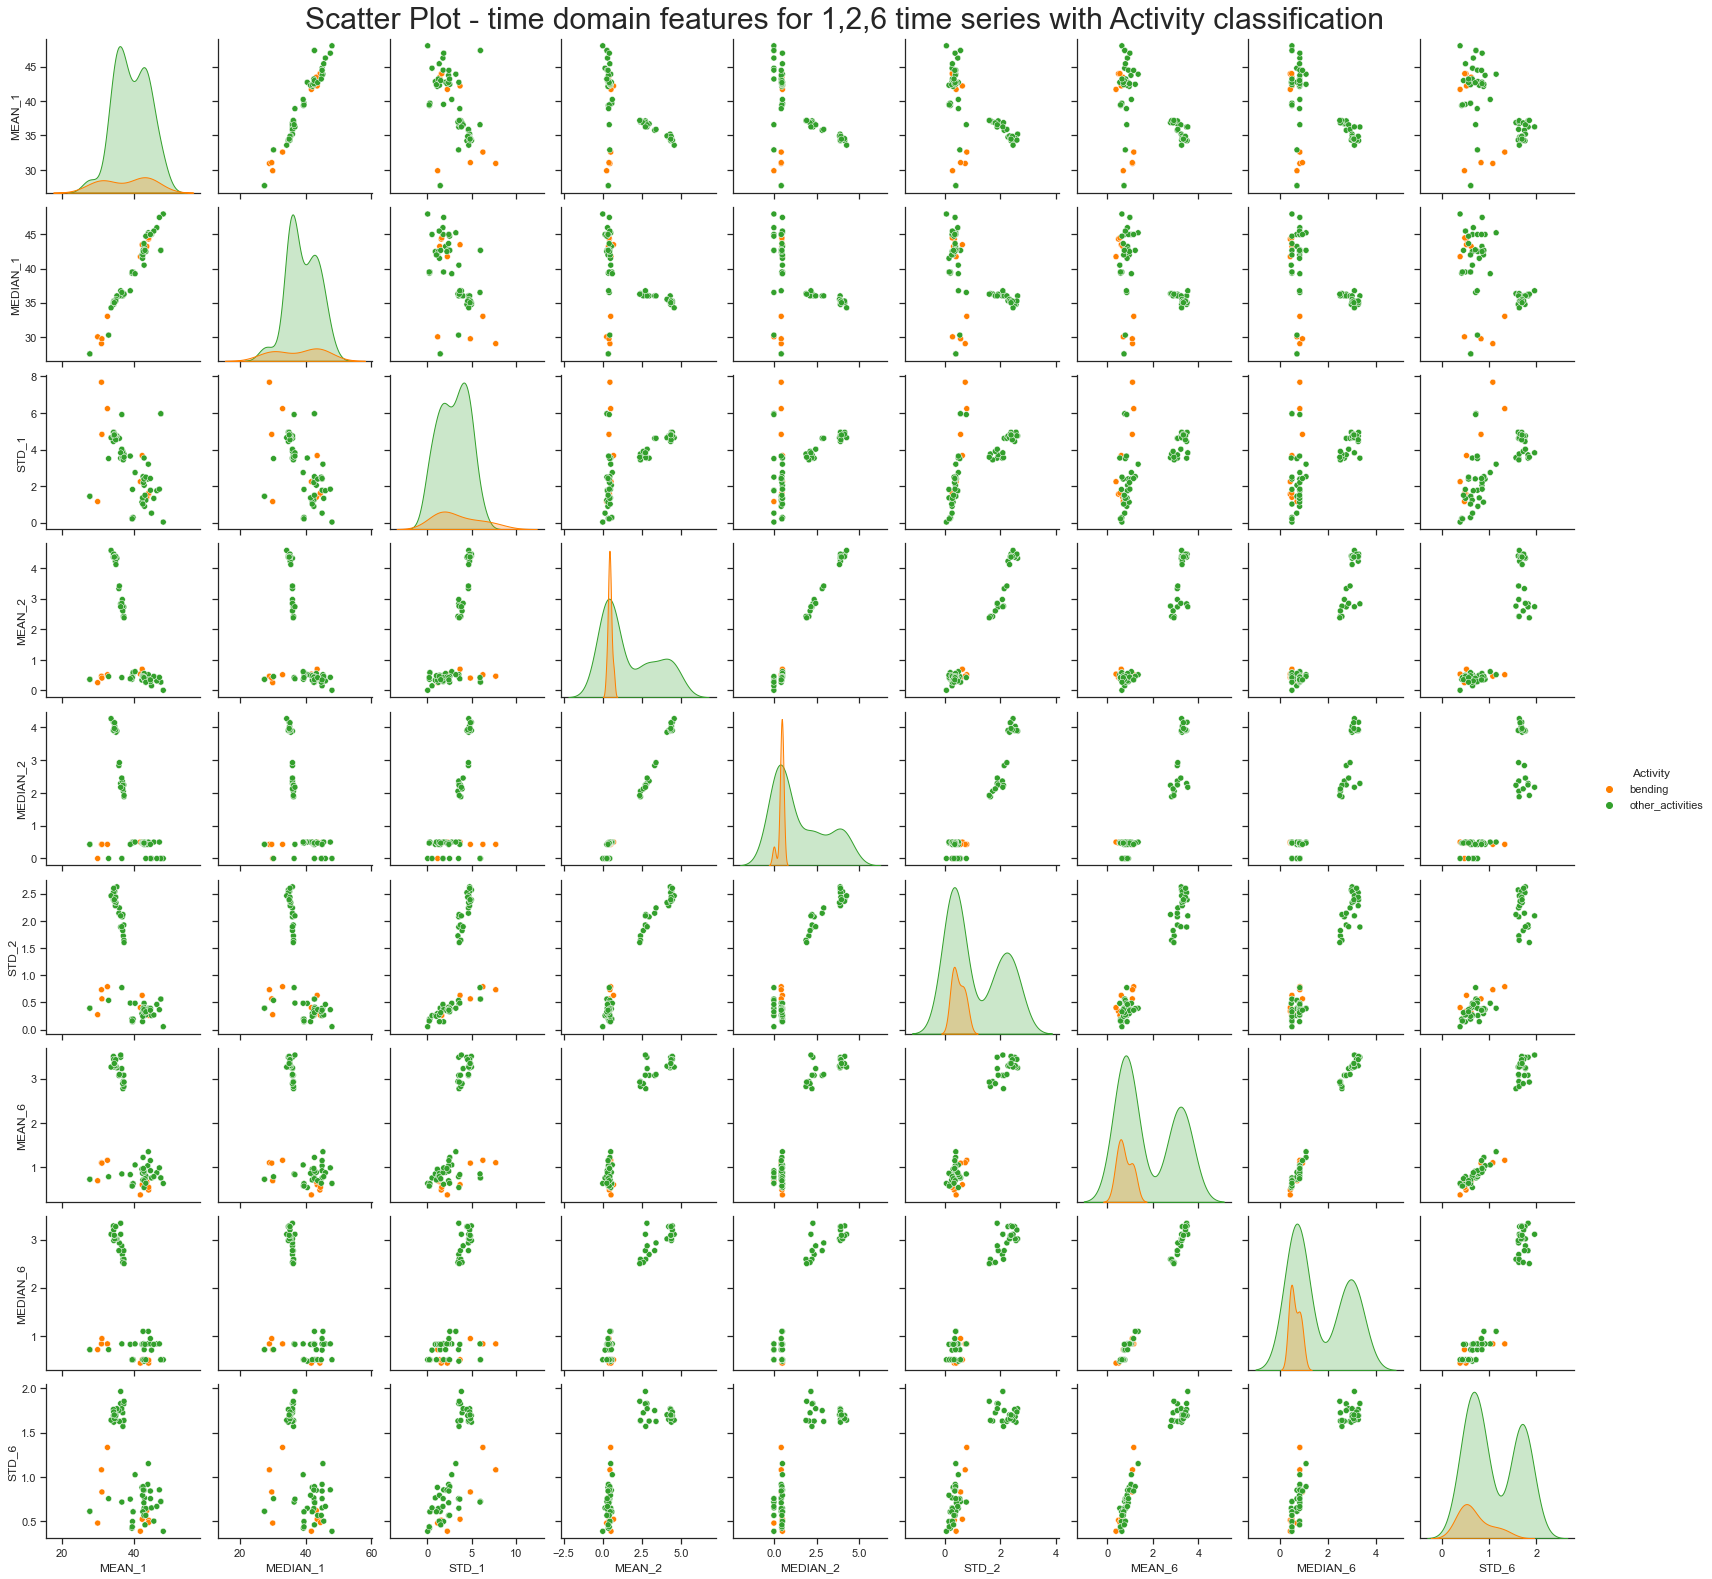

In [10]:
sns.set(style = 'ticks')
sns.pairplot(training_data_time_features_df  , hue = 'Activity',palette='Paired_r')
plt.suptitle("Scatter Plot - time domain features for 1,2,6 time series with Activity classification", fontsize = 30)
plt.subplots_adjust(top = 0.96)
plt.show()

ii.
Break each time series in your training set into two (approximately) equal
length time series. Now instead of 6 time series for each of the training
instances, you have 12 time series for each training instance. Repeat the
experiment in 4(a)i, i.e depict scatter plots of the features extracted from both
parts of the time series 1,2, and 6. Do you see any considerable difference in
the results with those of 4(a)i?

In [11]:

transformed_train_data_list=list()


merged_columns= ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23',
      'var_rss23', 'activity','time_extra', 'avg_rss12_extra', 'var_rss12_extra', 'avg_rss13_extra', 'var_rss13_extra', 'avg_rss23_extra',
      'var_rss23_extra', 'activity_extra']

##Considering 1,2,6 columns i.e. 'avg_rss12','var_rss12','var_rss23' columns and its splitted data's columns 'avg_rss12_extra','var_rss12_extra','var_rss23_extra'
required_timeseries_cols=['avg_rss12','var_rss12','var_rss23','avg_rss12_extra','var_rss12_extra','var_rss23_extra']

twelve_time_series_training_data_features=[]

for train_instance in train_dfs:
#     print(train_instance)

    #Getting activity type
    #A better and generic way to split is used for later questions. These lines of code are for just 2 plita
    activity=train_instance['activity'].iloc[0];
    splits = np.array_split(train_instance, 2)
    if len(splits[1])==239:
        first__239_rows = splits[0].iloc[0:239]
        last_row=splits[0].iloc[-1]
        transformed_instance = np.concatenate((first__239_rows,splits[1]),axis=1) 
    else:
        transformed_instance = np.concatenate((splits[0],splits[1]),axis=1) 
        
    transformed_instance_df=pd.DataFrame(transformed_instance, columns=merged_columns)
    curr_instance=[]
    for column in required_timeseries_cols:
        curr_instance.append(transformed_instance_df[column].mean())
        curr_instance.append(transformed_instance_df[column].median())
        curr_instance.append(transformed_instance_df[column].std())
    
    if (transformed_instance_df['activity'].iloc[0]=='bending1') or (transformed_instance_df['activity'].iloc[0]=='bending2'):
        curr_instance.append('bending');
    else:
        curr_instance.append('other_activities');
    twelve_time_series_training_data_features.append(curr_instance)

df_columns = ['MEAN_1','MEDIAN_1','STD_1','MEAN_2','MEDIAN_2','STD_2','MEAN_6','MEDIAN_6','STD_6',
              'MEAN_BREAK_1','MEDIAN_BREAK_1','STD_BREAK_1','MEAN_BREAK_2','MEDIAN_BREAK_2','STD_BREAK_2','MEAN_BREAK_BREAK_6','MEDIAN_BREAK_6','STD_BREAK_6',
              'Activity']

# print(twelve_time_series_training_data_features)
twelve_time_series_training_data_features_df=pd.DataFrame(twelve_time_series_training_data_features, columns=df_columns );
print("Total number of columns:",twelve_time_series_training_data_features_df.columns.size)
   
twelve_time_series_training_data_features_df

Total number of columns: 19


MEAN_1  MEDIAN_1     STD_1    MEAN_2  MEDIAN_2     STD_2    MEAN_6  \
0   44.057167    44.500  1.556971  0.381042     0.470  0.329540  0.598250   
1   43.278875    45.000  3.473355  0.673292     0.485  0.634285  0.640958   
2   41.621208    42.330  3.118644  0.623083     0.500  0.489595  0.419083   
3   44.117042    45.000  1.359836  0.250042     0.000  0.314099  0.815417   
4   43.486208    43.710  1.281976  0.378667     0.470  0.284434  0.524875   
..        ...       ...       ...       ...       ...       ...       ...   
64  33.334500    34.000  4.874433  4.408083     4.195  2.196206  3.229167   
65  34.036750    34.415  4.872880  4.778292     4.030  2.762730  3.543708   
66  34.033875    35.000  4.758757  4.574625     4.470  2.391804  3.244042   
67  34.920792    35.330  4.272282  4.177958     3.865  2.341763  3.430625   
68  34.916792    35.375  4.634209  4.262333     3.850  2.396878  3.439917   

    MEDIAN_6     STD_6  MEAN_BREAK_1  MEDIAN_BREAK_1  STD_BREAK_1  \
0      0.500  0.526656     43.851833          43.500     1.557168   
1      0.765  0.554542     41.080750          42.000     3.537481   
2      0.430  0.411200     41.734917          41.500     0.595920   
3      0.710  0.718016     42.792875          42.670     1.058792   
4      0.470  0.486847     44.452042          44.500     1.771251   
..       ...       ...           ...             ...          ...   
64     3.110  1.637310     33.839250          34.500     4.411903   
65     3.255  1.703098     34.608750          35.500     4.621400   
66     2.980  1.619767     35.058583          35.875     4.880650   
67     3.270  1.781928     34.825667          35.250     4.785599   
68     3.200  1.737420     34.029583          34.500     4.923609   

    MEAN_BREAK_2  MEDIAN_BREAK_2  STD_BREAK_2  MEAN_BREAK_BREAK_6  \
0       0.471458           0.500     0.342346            0.388333   
1       0.718792           0.500     0.627915            0.586083   
2       0.448875           0.500     0.273050            0.347500   
3       0.506125           0.500     0.260761            0.543875   
4       0.447583           0.500     0.235493            0.585750   
..           ...             ...          ...                 ...   
64      4.745042           4.320     2.694219            3.290292   
65      4.134375           3.740     2.387460            3.321417   
66      4.169292           3.880     2.315929            3.432208   
67      4.583208           4.070     2.514203            3.418667   
68      4.456292           4.195     2.381634            3.241000   

    MEDIAN_BREAK_6  STD_BREAK_6          Activity  
0            0.000     0.478528           bending  
1            0.470     0.491873           bending  
2            0.430     0.363144           bending  
3            0.500     0.473445           bending  
4            0.500     0.487918           bending  
..             ...          ...               ...  
64           3.155     1.646023  other_activities  
65           3.155     1.758379  other_activities  
66           3.255     1.691050  other_activities  
67           3.350     1.598536  other_activities  
68           3.060     1.657578  other_activities  

[69 rows x 19 columns]

In [12]:
transformed_instance_df

time avg_rss12 var_rss12 avg_rss13 var_rss13 avg_rss23 var_rss23  \
0        0     37.75      8.93     16.25      5.07      17.0      4.36   
1      250     35.25      2.49     11.33      4.92     13.67      2.36   
2      500     38.33      3.86     19.25      1.48     18.67      2.05   
3      750      40.5      3.57      17.5       1.8      16.0       6.2   
4     1000      30.0       0.0     19.67      1.89     16.75      3.42   
..     ...       ...       ...       ...       ...       ...       ...   
235  58750     39.75      4.92     14.75      2.38      17.5      2.69   
236  59000     31.75      8.55      14.5      2.29     17.25      2.86   
237  59250      25.5      3.84      15.0      3.94      13.0       4.3   
238  59500      36.5      4.27      16.0      7.79     18.67      4.78   
239  59750      37.0      1.22     15.33      2.05     16.67      1.25   

    activity time_extra avg_rss12_extra var_rss12_extra avg_rss13_extra  \
0    walking      60000           37.67            1.25           17.25   
1    walking      60250           39.75            3.11            9.75   
2    walking      60500           30.33            2.49           13.67   
3    walking      60750           20.75            6.76           11.25   
4    walking      61000           36.25            5.89            11.5   
..       ...        ...             ...             ...             ...   
235  walking     118750            34.5            6.18             9.0   
236  walking     119000           25.75            6.02           13.75   
237  walking     119250            31.5            3.35           10.25   
238  walking     119500           33.75            2.77            14.0   
239  walking     119750            37.0            1.41           18.25   

    var_rss13_extra avg_rss23_extra var_rss23_extra activity_extra  
0              0.83           13.67            6.13        walking  
1              3.96           17.33             3.3        walking  
2              5.79           22.33            0.94        walking  
3              3.96           22.25            4.26        walking  
4              5.68           18.25             3.9        walking  
..              ...             ...             ...            ...  
235            3.56           12.67            4.19        walking  
236            2.05            16.0            1.58        walking  
237            5.12           16.25            2.95        walking  
238            3.24           13.75            0.43        walking  
239             3.7            11.0            4.32        walking  

[240 rows x 16 columns]

In [13]:
merged_columns= ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23',
      'var_rss23', 'activity','time_extra', 'avg_rss12_extra', 'var_rss12_extra', 'avg_rss13_extra', 'var_rss13_extra', 'avg_rss23_extra',
      'var_rss23_extra', 'activity_extra']

transformed_instance_df=pd.DataFrame(transformed_instance, columns=merged_columns)
transformed_instance_df

time avg_rss12 var_rss12 avg_rss13 var_rss13 avg_rss23 var_rss23  \
0        0     37.75      8.93     16.25      5.07      17.0      4.36   
1      250     35.25      2.49     11.33      4.92     13.67      2.36   
2      500     38.33      3.86     19.25      1.48     18.67      2.05   
3      750      40.5      3.57      17.5       1.8      16.0       6.2   
4     1000      30.0       0.0     19.67      1.89     16.75      3.42   
..     ...       ...       ...       ...       ...       ...       ...   
235  58750     39.75      4.92     14.75      2.38      17.5      2.69   
236  59000     31.75      8.55      14.5      2.29     17.25      2.86   
237  59250      25.5      3.84      15.0      3.94      13.0       4.3   
238  59500      36.5      4.27      16.0      7.79     18.67      4.78   
239  59750      37.0      1.22     15.33      2.05     16.67      1.25   

    activity time_extra avg_rss12_extra var_rss12_extra avg_rss13_extra  \
0    walking      60000           37.67            1.25           17.25   
1    walking      60250           39.75            3.11            9.75   
2    walking      60500           30.33            2.49           13.67   
3    walking      60750           20.75            6.76           11.25   
4    walking      61000           36.25            5.89            11.5   
..       ...        ...             ...             ...             ...   
235  walking     118750            34.5            6.18             9.0   
236  walking     119000           25.75            6.02           13.75   
237  walking     119250            31.5            3.35           10.25   
238  walking     119500           33.75            2.77            14.0   
239  walking     119750            37.0            1.41           18.25   

    var_rss13_extra avg_rss23_extra var_rss23_extra activity_extra  
0              0.83           13.67            6.13        walking  
1              3.96           17.33             3.3        walking  
2              5.79           22.33            0.94        walking  
3              3.96           22.25            4.26        walking  
4              5.68           18.25             3.9        walking  
..              ...             ...             ...            ...  
235            3.56           12.67            4.19        walking  
236            2.05            16.0            1.58        walking  
237            5.12           16.25            2.95        walking  
238            3.24           13.75            0.43        walking  
239             3.7            11.0            4.32        walking  

[240 rows x 16 columns]

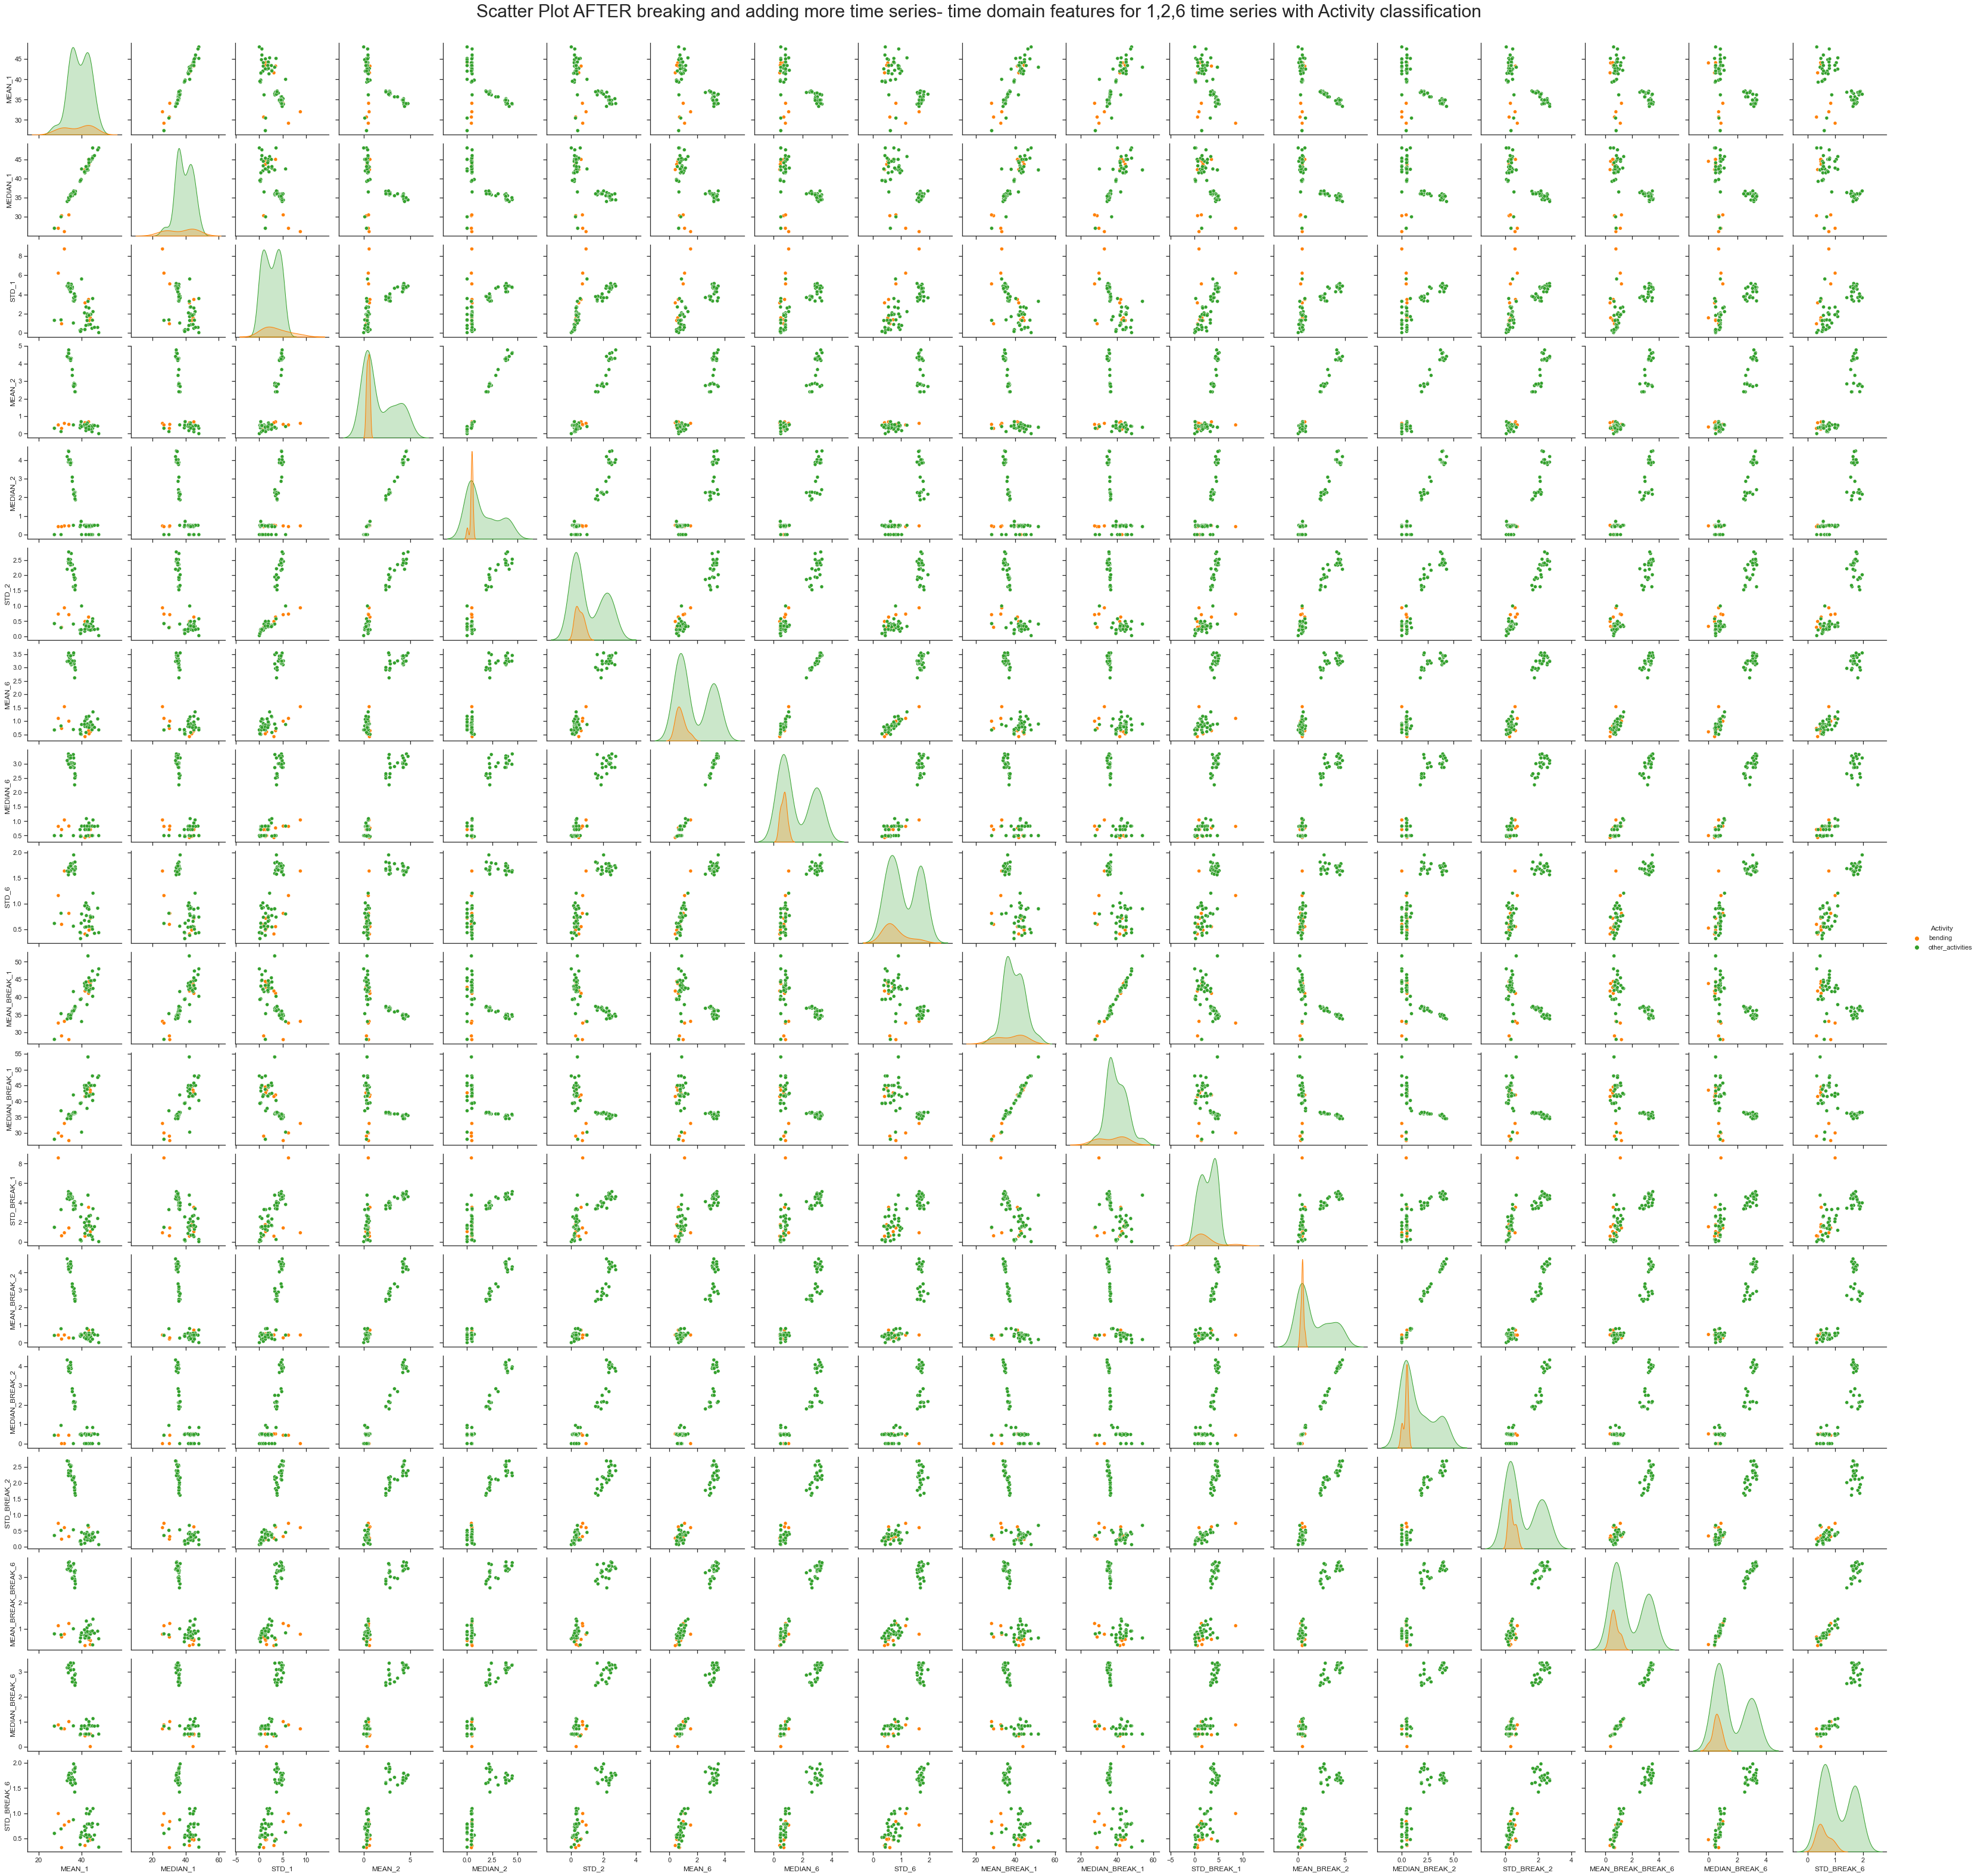

In [14]:
sns.set(style = 'ticks')
sns.pairplot(twelve_time_series_training_data_features_df , hue = 'Activity',palette='Paired_r')
plt.suptitle("Scatter Plot AFTER breaking and adding more time series- time domain features for 1,2,6 time series with Activity classification", fontsize = 30)
plt.subplots_adjust(top = 0.96)
plt.show()

In [15]:
twelve_time_series_training_data_features_df

MEAN_1  MEDIAN_1     STD_1    MEAN_2  MEDIAN_2     STD_2    MEAN_6  \
0   44.057167    44.500  1.556971  0.381042     0.470  0.329540  0.598250   
1   43.278875    45.000  3.473355  0.673292     0.485  0.634285  0.640958   
2   41.621208    42.330  3.118644  0.623083     0.500  0.489595  0.419083   
3   44.117042    45.000  1.359836  0.250042     0.000  0.314099  0.815417   
4   43.486208    43.710  1.281976  0.378667     0.470  0.284434  0.524875   
..        ...       ...       ...       ...       ...       ...       ...   
64  33.334500    34.000  4.874433  4.408083     4.195  2.196206  3.229167   
65  34.036750    34.415  4.872880  4.778292     4.030  2.762730  3.543708   
66  34.033875    35.000  4.758757  4.574625     4.470  2.391804  3.244042   
67  34.920792    35.330  4.272282  4.177958     3.865  2.341763  3.430625   
68  34.916792    35.375  4.634209  4.262333     3.850  2.396878  3.439917   

    MEDIAN_6     STD_6  MEAN_BREAK_1  MEDIAN_BREAK_1  STD_BREAK_1  \
0      0.500  0.526656     43.851833          43.500     1.557168   
1      0.765  0.554542     41.080750          42.000     3.537481   
2      0.430  0.411200     41.734917          41.500     0.595920   
3      0.710  0.718016     42.792875          42.670     1.058792   
4      0.470  0.486847     44.452042          44.500     1.771251   
..       ...       ...           ...             ...          ...   
64     3.110  1.637310     33.839250          34.500     4.411903   
65     3.255  1.703098     34.608750          35.500     4.621400   
66     2.980  1.619767     35.058583          35.875     4.880650   
67     3.270  1.781928     34.825667          35.250     4.785599   
68     3.200  1.737420     34.029583          34.500     4.923609   

    MEAN_BREAK_2  MEDIAN_BREAK_2  STD_BREAK_2  MEAN_BREAK_BREAK_6  \
0       0.471458           0.500     0.342346            0.388333   
1       0.718792           0.500     0.627915            0.586083   
2       0.448875           0.500     0.273050            0.347500   
3       0.506125           0.500     0.260761            0.543875   
4       0.447583           0.500     0.235493            0.585750   
..           ...             ...          ...                 ...   
64      4.745042           4.320     2.694219            3.290292   
65      4.134375           3.740     2.387460            3.321417   
66      4.169292           3.880     2.315929            3.432208   
67      4.583208           4.070     2.514203            3.418667   
68      4.456292           4.195     2.381634            3.241000   

    MEDIAN_BREAK_6  STD_BREAK_6          Activity  
0            0.000     0.478528           bending  
1            0.470     0.491873           bending  
2            0.430     0.363144           bending  
3            0.500     0.473445           bending  
4            0.500     0.487918           bending  
..             ...          ...               ...  
64           3.155     1.646023  other_activities  
65           3.155     1.758379  other_activities  
66           3.255     1.691050  other_activities  
67           3.350     1.598536  other_activities  
68           3.060     1.657578  other_activities  

[69 rows x 19 columns]

##  Observations in the two scatter plots 
#### Number of samples for bending is less compared to other activities. It shows the imbalance of data if we are to classify only two classes-bending and other activities. 
#### In new scatterplots after the break , there is an addition of features - with more features, its help us better sense of how the feature correlate with each other, although from the two plots, there is no significant difference


iii.
Break each time series in your training set into
l
∈ {
1
,
2
, . . . ,
20
}
time series
of approximately equal length and use logistic regression
5
to solve the binary
classification problem, using time-domain features. Remember that breaking
each of the time series does not change the number of instances. It only
changes the number of features for each instance. Calculate the p-values for
your logistic regression parameters in each model corresponding to each value
of
l
and refit a logistic regression model using your pruned set of features.
6
Alternatively, you can use backward selection using sklearn.feature
selection
or glm in R. Use 5-fold cross-validation to determine the best value of the pair
(
l, p
), where
p
is the number of features used in recursive feature elimination.
Explain what the right way and the wrong way are to perform cross-validation
in this problem.
7
Obviously, use the right way! Also, you may encounter the
problem of class imbalance, which may make some of your folds not having
any instances of the rare class. In such a case, you can use
stratifiedcross
validation.

### Choosing the best (l,p) value using Recursive feature elimination with cross-validation

Class 0 is Bending and class 2 is Other Activities

In [16]:
timeseries_column_names=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']

def split_Dataframe(df, splits):
    dataframes = []
    index_to_split = len(df) // splits
    start = 0
    end = index_to_split
    no_of_remaining_rows=len(df)%splits;
    initialRow=True;
    for split in range(splits):
        if initialRow==True:
            end=end+no_of_remaining_rows;
            initialRow=False;
        temporary_df = df.iloc[start:end, :]
        dataframes.append(temporary_df)
        start += index_to_split
        end += index_to_split
    return dataframes

def concat_dataframes(list_of_dataframes):
    for dataframe in list_of_dataframes:
        dataframe.reset_index(drop=True, inplace=True);
    result = pd.concat(list_of_dataframes, axis=1) 
    return result;

def get_feature_column_names(no_of_segments,  timeseries_column_names):
    columns=[]
    for segment in range(1,no_of_segments+1,1):
        for col in timeseries_column_names:
            columns.append('MEAN_'+ col+'_SPLIT_'+str(segment));
            columns.append('MEDIAN_'+ col+'_SPLIT_'+str(segment));
            columns.append('STD_'+ col+'_SPLIT_'+str(segment));
    return columns       

def get_time_domain_features_after_split_and_merge(dfs, split_value):
    data_features=[]
    timeseries_column_names=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
    for instance in dfs:
        activity=instance['activity'].iloc[0];

        ##Creating a copy of the instance csv file with only relevant columns - ignoring time and activity columns
        instance_copy=instance[timeseries_column_names].copy()
        list_of_dataframes = split_Dataframe(instance_copy,split_value)
        curr_instance=[]
        for split_df in list_of_dataframes:
            for column in timeseries_column_names:
                curr_instance.append(split_df[column].mean())
                curr_instance.append(split_df[column].median())
                curr_instance.append(split_df[column].std())

        if (activity=='bending1') or (activity=='bending2'):
            curr_instance.append(0);
        else:
            curr_instance.append(1);

        data_features.append(curr_instance);
    return data_features

def get_predictors_and_target_variable(L,data_features):
    column_names = get_feature_column_names(L, timeseries_column_names)
    column_names.append('Activity');
    features_df=pd.DataFrame(data_features,columns=column_names)
    ##display(features_df)
    features_df_copy=features_df.copy()
    data_y=features_df_copy['Activity']
    features_df_copy.drop('Activity', axis=1, inplace=True)
    data_x=features_df_copy;
    return data_x,data_y;


list_of_p=[]
cv_scores=[]
for L in range(1,21,1):
    # contains time domain features (mean, median, std) of the time series - 'avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23'
    training_data_features=get_time_domain_features_after_split_and_merge(train_dfs,L);
    train_x, train_y = get_predictors_and_target_variable(L, training_data_features)
#     model = LogisticRegression(penalty='none', solver='newton-cg')
#     model = LogisticRegression(penalty='none')

##USING LIBLINEAR SETTING C as a HIGH VALUE
    penalty_none_model = LogisticRegression(solver='liblinear',C=sys.maxsize)
    rfecv = RFECV(estimator = penalty_none_model, cv=StratifiedKFold(5), scoring = 'accuracy')
    rfecv.fit(train_x, train_y)
#     print(rfecv.grid_scores_)
    print("For l=",L,"optimal number of features, p is",rfecv.n_features_)
    print("Maximum cross validation(accuracy) is ", np.max(rfecv.grid_scores_))

    list_of_p.append(rfecv.n_features_)  
    cv_scores.append(np.max(rfecv.grid_scores_))


l=np.arange(1,21,1);
p_cv_scores_df= pd.DataFrame({'Split val: L':l,'optimal p': list_of_p, 'CV score':cv_scores})
p_cv_scores_df

For l= 1 optimal number of features, p is 8
Maximum cross validation(accuracy) is  0.9417582417582417
For l= 2 optimal number of features, p is 19
Maximum cross validation(accuracy) is  0.9274725274725275
For l= 3 optimal number of features, p is 6
Maximum cross validation(accuracy) is  0.9571428571428571
For l= 4 optimal number of features, p is 33
Maximum cross validation(accuracy) is  0.9714285714285715
For l= 5 optimal number of features, p is 21
Maximum cross validation(accuracy) is  0.9714285714285715
For l= 6 optimal number of features, p is 15
Maximum cross validation(accuracy) is  0.9857142857142858
For l= 7 optimal number of features, p is 12
Maximum cross validation(accuracy) is  0.9714285714285715
For l= 8 optimal number of features, p is 45
Maximum cross validation(accuracy) is  0.9714285714285715
For l= 9 optimal number of features, p is 4
Maximum cross validation(accuracy) is  0.9714285714285715
For l= 10 optimal number of features, p is 149
Maximum cross validation(accu

Split val: L  optimal p  CV score
0              1          8  0.941758
1              2         19  0.927473
2              3          6  0.957143
3              4         33  0.971429
4              5         21  0.971429
5              6         15  0.985714
6              7         12  0.971429
7              8         45  0.971429
8              9          4  0.971429
9             10        149  0.985714
10            11        139  0.985714
11            12         95  0.971429
12            13         34  0.985714
13            14         20  0.957143
14            15        124  0.985714
15            16         69  0.971429
16            17        104  0.985714
17            18        152  0.985714
18            19        229  0.985714
19            20         14  0.971429

In [17]:
max_cv_index = cv_scores.index(max(cv_scores))
best_l = max_cv_index+1
best_p=list_of_p[max_cv_index]
print("Best (l,p) pair: ", (best_l, best_p))
print("So the optimal number of features achieved (p) is ", best_p)
print("This 'p' value is found when l is",best_l)
print("The best cross validation score or accuracy achieved is ", max(cv_scores))

Best (l,p) pair:  (6, 15)
So the optimal number of features achieved (p) is  15
This 'p' value is found when l is 6
The best cross validation score or accuracy achieved is  0.9857142857142858


### OBSERVATIONS
#### The right way is to include selection of predictors in the k-fold cross validation process. Predictor selection using cross validation is a form of training and must be included in the evaluation process.The right way is to select set of predictors based on the k-fold cross validation and do the selection again in each of the k steps in cross validation. Here,we include feature selection a part of the process while training the model. THe number of features changes based on L and for each L, k-cross validation process happens. We choose the best L based on cv score. 
#### The wrong way is to select the features first (without cross validation process) and then perfom k fold cross validation


iv.
Report the confusion matrix and show the ROC and AUC for your classifier
on train data. Report the parameters of your logistic regression
β
i
’s as well
as the p-values associated with them.

## Final regression model (using the optimal p features as listed above- from best l)

### Displaying Confusion Matrix 

In [18]:
import sys

##putting  best p into the rfe. 
##Another way is to store the significant features while running loop (L-1 to 20)  , and use thise features to create a linear regression model
## Here I am building the model using just the  best p value we found earlier. Train data is built according to the best L


##Building the model for best l and p we have achieved
features=get_time_domain_features_after_split_and_merge(train_dfs,best_l);
train_x,train_y=get_predictors_and_target_variable(best_l,features);

model = LogisticRegression(solver='liblinear', C=sys.maxsize);
rfe = RFE(model,best_p)
rfe.fit(train_x, train_y)

pred_tr_y = rfe.predict(train_x)
cf_matrix = confusion_matrix(train_y,pred_tr_y )
print("CONFUSION MATRIX")
print(cf_matrix)

selected_p_features = list(train_x.columns[rfe.support_])
print("\n \nAs shown in previous cell, Number of optimal features", len(selected_p_features))
print("\n p Optimal features:",selected_p_features,"\n" )


CONFUSION MATRIX
[[ 9  0]
 [ 0 60]]

 
As shown in previous cell, Number of optimal features 15

 p Optimal features: ['MEAN_avg_rss23_SPLIT_1', 'MEDIAN_avg_rss23_SPLIT_1', 'STD_avg_rss12_SPLIT_2', 'MEAN_avg_rss23_SPLIT_2', 'MEAN_var_rss23_SPLIT_2', 'MEAN_var_rss23_SPLIT_3', 'MEDIAN_avg_rss12_SPLIT_4', 'STD_avg_rss12_SPLIT_4', 'MEAN_var_rss12_SPLIT_4', 'STD_avg_rss23_SPLIT_4', 'MEAN_avg_rss12_SPLIT_5', 'MEAN_var_rss12_SPLIT_5', 'MEDIAN_avg_rss13_SPLIT_5', 'MEAN_avg_rss13_SPLIT_6', 'MEAN_avg_rss23_SPLIT_6'] 



From the confusion matrix above, we can see that there are no misclasssification - no false positives or no false negatives, 

### ROC and AUC

Area Under the Receiver Operating Characteristic Curve is  1.0


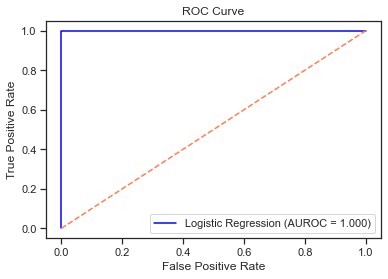

In [19]:
r_auc_score = roc_auc_score(train_y,pred_tr_y)
print("Area Under the Receiver Operating Characteristic Curve is ", r_auc_score)

rfe_probs = rfe.predict_proba(train_x)
rfe_probs = rfe_probs[:, 1]

r_fpr, r_tpr, thresholds = roc_curve(train_y,rfe_probs)

plt.plot(r_fpr, r_tpr, 'blue',label='Logistic Regression (AUROC = %0.3f)' % r_auc_score)
plt.plot([0, 1], [0, 1],'coral',  linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()

### Beta Coefficients and p-values in the model

In [20]:
train_x_with_intercept = sm.add_constant(train_x[selected_p_features])
logit_model = sm.Logit(train_y,train_x_with_intercept).fit(method='bfgs',maxiter=3)
# method='cg'
# method='ncg'
# logit_model = sm.Logit(train_y,train_x_with_intercept).fit(method='bfgs', maxiter=0.2)
print("\n*****************SUMMARY******************\n")
print(logit_model.summary())

###TODO: try with GLM too

print("\n")

         Current function value: 0.055139
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6

*****************SUMMARY******************

                           Logit Regression Results                           
Dep. Variable:               Activity   No. Observations:                   69
Model:                          Logit   Df Residuals:                       53
Method:                           MLE   Df Model:                           15
Date:                Sun, 06 Mar 2022   Pseudo R-squ.:                  0.8576
Time:                        12:05:23   Log-Likelihood:                -3.8046
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 5.666e-05
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const 

v) Test the classifier on the test set. Remember to break the time series in
your test set into the same number of time series into which you broke your
training set. Remember that the classifier has to be tested using the features
extracted from the test set. Compare the accuracy on the test set with the
cross-validation accuracy you obtained previously

In [21]:
##Breaking test data - splitting
test_new_features=get_time_domain_features_after_split_and_merge(test_dfs,best_l)
test_new_x, test_new_y = get_predictors_and_target_variable(best_l, test_new_features)

##rfe score Reduce test_new_x to the selected features and then return the score of the underlying estimator.
print("Score with test data:", rfe.score(test_new_x,test_new_y))

pred_te_y = rfe.predict(test_new_x)

cf_matrix_te = confusion_matrix(test_new_y,pred_te_y )
print("\n CONFUSION MATRIX -TEST DATA")
print(cf_matrix_te)

Score with test data: 1.0

 CONFUSION MATRIX -TEST DATA
[[ 4  0]
 [ 0 15]]


## Observations and Findings
#### Max cross validation score observed is 0.985714 and the accuracy score on the test data with the best l is 1.This means the model we built with best l selected through cross validation, is working well, as the test accuracy rate is 1.
#### There is small difference in the accuracy score of the cv score and test score. Usually, we think that CV score is more than test accuracy since we deal with unseen data in testing. However, the test accuracy could sometimes be more, due to improper division of data into train,test, validation data. If there is a significant difference in the accuracy of test data i.e. test accuracy way higher than cv score, then there could be some issue. Here , there is a very small difference.



vi. Do your classes seem to be well-separated to cause instability in calculating
logistic regression parameters?

#### Yes, the classes seem well separated to cause instability in calculating logistic parameters. Moreover, the data is imbalanced- lots of other-activities as labels and very few as bending.
#### P-values are close to 1. And max-iter had to be set to 3, to control the perfect separation between the classes.
####  Stratified k fold validation with cv as 5  is used

vii.
From the confusion matrices you obtained, do you see imbalanced classes?
If yes, build a logistic regression model based on case-control sampling and
adjust its parameters. Report the confusion matrix, ROC, and AUC of the
model.

#### Yes, there are imbalanced classes. From the confusion matrix, we can see that the number of instances with 'bending' is quite less compared to 'other activities'. To deal with imbalance, we can oversample or undersample as seen in the next cells.

ROC AUC score for oversampled SMOTE TRAIN data:  1.0
Accuracy score - Training Data : 1.0

CONFUSION MATRIX - CASE SAMPLING TRAIN DATA
[[60  0]
 [ 0 60]]


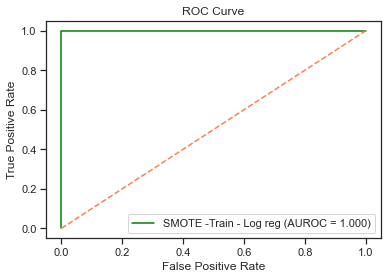

ROC AUC-area under curve for oversampled SMOTE TEST data:  1.0
Accuracy score - Testing Data : 1.0
CONFUSION MATRIX - CASE SAMPLING TEST DATA
[[ 4  0]
 [ 0 15]]


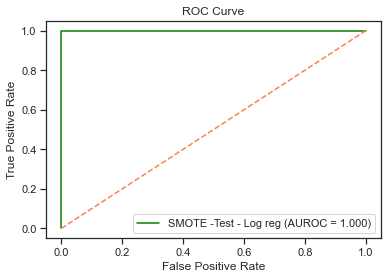

In [22]:
def drawROCcurve(roc_auc, y, pred_prob, label):
    fpr, tpr, thresholds = roc_curve(y,pred_prob)
    plt.plot(fpr, tpr, 'green',label='SMOTE -'+label+' - Log reg (AUROC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'coral',  linestyle='--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend() 
    plt.show()

features=get_time_domain_features_after_split_and_merge(train_dfs,best_l);
train_x,train_y=get_predictors_and_target_variable(best_l,features);
train_x_selected_features=train_x[selected_p_features]

smote = SMOTE(sampling_strategy='all')
#smote = SMOTE()

train_x_smote, train_y_smote = smote.fit_resample(train_x_selected_features,train_y)

log_reg = LogisticRegression(solver='liblinear', C=sys.maxsize);
smote_log_reg = log_reg.fit(train_x_smote,train_y_smote)

#####Predicting Train data y, calculate confusion matrix, test data score, ROC-AUC
pred_train_y_smote = smote_log_reg.predict(train_x_smote)
roc_auc = roc_auc_score(train_y_smote, pred_train_y_smote)
print("ROC AUC score for oversampled SMOTE TRAIN data: ", roc_auc)
tr_accuracy=smote_log_reg.score(train_x_smote,train_y_smote)
print("Accuracy score - Training Data :",tr_accuracy)

smote_cf_matrix = confusion_matrix(train_y_smote,pred_train_y_smote)
print("\nCONFUSION MATRIX - CASE SAMPLING TRAIN DATA")
print(smote_cf_matrix)

sm_pred_tr_probs =smote_log_reg.predict_proba(train_x_smote)[:, 1]

drawROCcurve(roc_auc, train_y_smote , sm_pred_tr_probs,'Train')


#####Predicting Test data, calculate confusion matrix, test data score, ROC-AUC
test_X_with_selected_features = test_new_x[selected_p_features]
pred_test_y_smote = smote_log_reg.predict(test_X_with_selected_features)
roc_auc_te=roc_auc_score(test_new_y, pred_test_y_smote)
print("ROC AUC-area under curve for oversampled SMOTE TEST data: ", roc_auc_te)
te_accuracy=smote_log_reg.score(test_X_with_selected_features, test_new_y)
print("Accuracy score - Testing Data :",te_accuracy)


smote_cf_matrix_test = confusion_matrix(test_new_y, pred_test_y_smote )
print("CONFUSION MATRIX - CASE SAMPLING TEST DATA")
print(smote_cf_matrix_test)


sm_pred_te_probs =smote_log_reg.predict_proba(test_X_with_selected_features)[:, 1]

drawROCcurve(roc_auc_te, test_new_y , sm_pred_te_probs,'Test')


(b)
Binary Classification Using
L
1
-penalized logistic regression

i.
Repeat 2(a)iii using
L
1
-penalized logistic regression,

i.e. instead of using p-
values for variable selection, use
L
1
regularization. Note that in this problem,
you have to cross-validate for both
l
, the number of time series into which you
break each of your instances, and
λ
, the weight of
L
1
penalty in your logistic
regression objective function (or
C
, the budget). Packages usually perform
cross-validation for
λ
automatically.

### Binary Classification Using L 1 -penalized logistic regression

In [23]:
l1_cv_scores=[]
p=[]
best_c_vals=[]

for L in range(1,21,1):
    # contains time domain features (mean, median, std) of the time series - 'avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23'
    l1_training_data_features=get_time_domain_features_after_split_and_merge(train_dfs,L);
    l1_train_x, l1_train_y = get_predictors_and_target_variable(L, l1_training_data_features)
    scalar = StandardScaler()
    l1_train_x_scaled = scalar.fit_transform(l1_train_x)

    grid_values = {'penalty': ['l1'],'C':[0.001,.009,0.01,.09,1,2,3,4,5,6,7,8,9,10,25,40,50,60,70,80,90,100],'solver': ['liblinear']}

    GS = GridSearchCV(LogisticRegression(),param_grid=grid_values,cv=5,scoring='accuracy')
    GS.fit(l1_train_x_scaled, l1_train_y)
    
    ##Creating log reg with the best c found in grid search
    log_reg=LogisticRegression(C= GS.best_params_.get('C'), penalty='l1', solver='liblinear')
    log_reg.fit(l1_train_x_scaled, l1_train_y)                            
    l1_selected_features = np.sum(log_reg.coef_ != 0)
                                                     
    print("l value:", L)
    best_c= GS.best_params_.get('C');
    print('For l=',L,'Best c val:',best_c);
    print('Selected p features length: {}',l1_selected_features)
    print('For l=',L,' Best CV Score:', GS.best_score_)
                               
        
     ##ANOTHER possible way to do for self exploration
    
#     l1model = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5, Cs=10)
#     l1model.fit(l1_train_x_scaled,l1_train_y)
#     result = cross_val_score(estimator= l1model, X=l1_train_x_scaled,cv=5, y=l1_train_y,scoring='accuracy')
#     print("Cross Validation score using cross val:",result.mean())
#     non_zero_coeff=np.sum(l1model.coef_ != 0)
#     p.append(non_zero_coeff);
#     l1_cv_scores.append(result.mean())
#     print("Number of selected features: ",non_zero_coeff)
#     print("Cross Validation score using l1model scores:", l1model.scores_[1].mean(axis=0).max())
    

    p.append(l1_selected_features)
    l1_cv_scores.append(GS.best_score_)
    best_c_vals.append(best_c);

    
l=np.arange(1,21,1);
l1_cv_scores_df= pd.DataFrame({'Split val: L':l,'p':p,'C':best_c_vals, 'CV score':l1_cv_scores})
l1_cv_scores_df

l value: 1
For l= 1 Best c val: 2
Selected p features length: {} 6
For l= 1  Best CV Score: 0.9417582417582417
l value: 2
For l= 2 Best c val: 2
Selected p features length: {} 9
For l= 2  Best CV Score: 0.9571428571428573
l value: 3
For l= 3 Best c val: 2
Selected p features length: {} 7
For l= 3  Best CV Score: 0.9714285714285715
l value: 4
For l= 4 Best c val: 1
Selected p features length: {} 8
For l= 4  Best CV Score: 0.9714285714285715
l value: 5
For l= 5 Best c val: 2
Selected p features length: {} 10
For l= 5  Best CV Score: 0.9571428571428573
l value: 6
For l= 6 Best c val: 1
Selected p features length: {} 9
For l= 6  Best CV Score: 0.9714285714285715
l value: 7
For l= 7 Best c val: 1
Selected p features length: {} 10
For l= 7  Best CV Score: 0.956043956043956
l value: 8
For l= 8 Best c val: 2
Selected p features length: {} 14
For l= 8  Best CV Score: 0.9417582417582417
l value: 9
For l= 9 Best c val: 1
Selected p features length: {} 12
For l= 9  Best CV Score: 0.941758241758241

Split val: L   p   C  CV score
0              1   6   2  0.941758
1              2   9   2  0.957143
2              3   7   2  0.971429
3              4   8   1  0.971429
4              5  10   2  0.957143
5              6   9   1  0.971429
6              7  10   1  0.956044
7              8  14   2  0.941758
8              9  12   1  0.941758
9             10  12   4  0.985714
10            11  12   1  0.957143
11            12  10   2  0.971429
12            13   8   1  0.957143
13            14  10   1  0.957143
14            15  13   1  0.956044
15            16  11   1  0.956044
16            17  17  25  0.971429
17            18  11   1  0.956044
18            19  12   2  0.970330
19            20  13   2  0.985714

In [24]:
l1_max_cv_index = l1_cv_scores.index(max(l1_cv_scores))
best_l_l1 = l1_max_cv_index+1
best_p_l1=p[l1_max_cv_index]
c_val_best_score=best_c_vals[l1_max_cv_index]
print("Best (l,p) pair: ", (best_l_l1, best_p_l1))
print("So the optimal number of features achieved (p) is ", best_p_l1)
print("This 'p' value is found when l is",best_l_l1)
print("Best C value is: ", c_val_best_score)
print("The best cross validation score or accuracy achieved is ", max(l1_cv_scores))

Best (l,p) pair:  (10, 12)
So the optimal number of features achieved (p) is  12
This 'p' value is found when l is 10
Best C value is:  4
The best cross validation score or accuracy achieved is  0.9857142857142858


ii.
Compare the
L
1
-penalized with variable selection using p-values. Which one
performs better? Which one is easier to implement?

### Comparison of L1-penalized and variable selection with p-values

##### The L1 penalized cell ran much faster than that of variable selection with p-values. The L1 penalized is much easier to implement and L1 penalized performs better
##### The number of features selected in L1-penalized is lesser than that of the number of selected features in p-value method. 
##### The L1 method also add regularization, helps to avoid overfitting. The CV scores are similar in both ways.
##### Without scaling, the cv was less overall. So I used normalized features 

(c)
Multi-class Classification (The Realistic Case)

Find the best
l
in the same way as you found it in 2(b)i to build an
L
1
-
penalized multinomial regression model to classify all activities in your train-
ing set.
10
Report your test error. Research how confusion matrices and ROC
curves are defined for multiclass classification and show them for this problem
if possible

### L 1 - penalized multinomial regression model

In [25]:
def get_time_domain_features_splitted_merged_multimonial(dfs, split_value):
    data_features=[]
    timeseries_column_names=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
    for instance in dfs:
        activity=instance['activity'].iloc[0];

        ##Creating a copy of the instance csv file with only relevant columns - ignoring time and activity columns
        instance_copy=instance[timeseries_column_names].copy()
        list_of_dataframes = split_Dataframe(instance_copy,split_value)
        curr_instance=[]
        for split_df in list_of_dataframes:
            for column in timeseries_column_names:
                curr_instance.append(split_df[column].mean())
                curr_instance.append(split_df[column].median())
                curr_instance.append(split_df[column].std())

        if (activity=='bending1') :
            curr_instance.append(1);
        if (activity=='bending2') :
            curr_instance.append(2);
        if (activity=='cycling') :
            curr_instance.append(3);
        if (activity=='lying') :
            curr_instance.append(4);
        if (activity=='sitting') :
            curr_instance.append(5);
        if (activity=='standing') :
            curr_instance.append(6);
        if (activity=='walking') :
            curr_instance.append(7);
    
        data_features.append(curr_instance);
    return data_features


In [26]:

multi_cv_scores=[]
multi_p=[]
multi_best_c_vals=[]
multi_te_errors=[]

for L in range(1,21,1):
    # contains time domain features (mean, median, std) of the time series - 'avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23'
    multi_training_data_features=get_time_domain_features_splitted_merged_multimonial(train_dfs,L);
    multi_l1_train_x, multi_l1_train_y = get_predictors_and_target_variable(L, multi_training_data_features)

    scalar = StandardScaler()
    multi_train_x_scaled = scalar.fit_transform(multi_l1_train_x)
    

    grid_values = {'penalty': ['l1'],'C':[0.001,.009,0.01,.09,1,2,3,4,5,6,7,8,9,10,25,40,50,60,70,80,90,100],'solver': ['liblinear']}

    GS = GridSearchCV(LogisticRegression(),param_grid=grid_values,cv=5,scoring='accuracy')
    GS.fit(multi_train_x_scaled, multi_l1_train_y)
    
    ##Creating log reg with the best c found in grid search
    multi_log_reg=LogisticRegression(C= GS.best_params_.get('C'), penalty='l1', solver='liblinear',multi_class='auto')
    multi_log_reg.fit(multi_train_x_scaled, multi_l1_train_y)                            
    multi_l1_selected_features = np.sum(multi_log_reg.coef_ != 0)

    best_c= GS.best_params_.get('C');
    print('multinomial: For l=',L,'Best c val:',best_c);
    print('multinomial: For l=',L,'Selected p features length:',multi_l1_selected_features)
    print('multinomial: For l=',L,' Best CV Score:', GS.best_score_)
    
    multi_p.append(multi_l1_selected_features)
    multi_cv_scores.append(GS.best_score_)
    multi_best_c_vals.append(best_c);
    multi_te_errors.append(1-multi_log_reg.score(multi_train_x_scaled,multi_l1_train_y))
    

l=np.arange(1,21,1);
multi_cv_scores_df= pd.DataFrame({'Split val: L':l,'p':multi_p,'C':multi_best_c_vals, 'CV score':multi_cv_scores, 'Test Error':multi_te_errors})
multi_cv_scores_df

multinomial: For l= 1 Best c val: 1
multinomial: For l= 1 Selected p features length: 33
multinomial: For l= 1  Best CV Score: 0.9285714285714286
multinomial: For l= 2 Best c val: 1
multinomial: For l= 2 Selected p features length: 51
multinomial: For l= 2  Best CV Score: 0.8406593406593407
multinomial: For l= 3 Best c val: 90
multinomial: For l= 3 Selected p features length: 97
multinomial: For l= 3  Best CV Score: 0.8252747252747253
multinomial: For l= 4 Best c val: 2
multinomial: For l= 4 Selected p features length: 71
multinomial: For l= 4  Best CV Score: 0.8263736263736263
multinomial: For l= 5 Best c val: 2
multinomial: For l= 5 Selected p features length: 86
multinomial: For l= 5  Best CV Score: 0.8263736263736263
multinomial: For l= 6 Best c val: 1
multinomial: For l= 6 Selected p features length: 77
multinomial: For l= 6  Best CV Score: 0.8120879120879121
multinomial: For l= 7 Best c val: 1
multinomial: For l= 7 Selected p features length: 89
multinomial: For l= 7  Best CV Sco

Split val: L    p    C  CV score  Test Error
0              1   33    1  0.928571    0.043478
1              2   51    1  0.840659    0.014493
2              3   97   90  0.825275    0.000000
3              4   71    2  0.826374    0.000000
4              5   86    2  0.826374    0.000000
5              6   77    1  0.812088    0.000000
6              7   89    1  0.797802    0.000000
7              8  104    4  0.783516    0.000000
8              9  112    4  0.812088    0.000000
9             10   87    1  0.798901    0.000000
10            11   83    1  0.783516    0.000000
11            12  128    5  0.782418    0.000000
12            13  108    2  0.738462    0.000000
13            14   96    1  0.812088    0.000000
14            15  211  100  0.826374    0.000000
15            16  141    5  0.753846    0.000000
16            17  100    1  0.826374    0.000000
17            18  216   70  0.783516    0.000000
18            19  137    3  0.769231    0.000000
19            20  108    1  0.768132    0.000000

In [27]:
print("************L 1 - penalized multinomial regression model**************\n")
multi_max_cv_index = multi_cv_scores.index(max(multi_cv_scores))
best_l_multi = multi_max_cv_index+1
best_p_multi=multi_p[multi_max_cv_index]
multi_c_val_best_score=multi_best_c_vals[multi_max_cv_index]
print("Best (l,p) pair: ", (best_l_multi, best_p_multi))
print("So the optimal number of features achieved (p) is ", best_p_multi)
print("This 'p' value is found when l is",best_l_multi)
print("Best C value is: ", multi_c_val_best_score)
print("The best cross validation score or accuracy achieved is ", max(multi_cv_scores))

************L 1 - penalized multinomial regression model**************

Best (l,p) pair:  (1, 33)
So the optimal number of features achieved (p) is  33
This 'p' value is found when l is 1
Best C value is:  1
The best cross validation score or accuracy achieved is  0.9285714285714286


### REPORT for the multinomial model created with the best l found in previous cell

In [28]:
##We will use the model created with best_l_multi to evaluate different metrics
multi_training_data_features=get_time_domain_features_splitted_merged_multimonial(train_dfs,best_l_multi);
multi_l1_train_x, multi_l1_train_y = get_predictors_and_target_variable(best_l_multi, multi_training_data_features)
multi_test_new_features=get_time_domain_features_splitted_merged_multimonial(test_dfs,best_l_multi)
multi_test_new_x, multi_test_new_y = get_predictors_and_target_variable(best_l_multi, multi_test_new_features)

multi_best_l_log_reg=LogisticRegression(C= multi_c_val_best_score, penalty='l1', solver='liblinear')
multi_best_l_log_reg.fit(multi_l1_train_x, multi_l1_train_y)                            

##Train Data Related Metrics

pred_tr_multi_y = multi_best_l_log_reg.predict(multi_l1_train_x)
multi_cf_matrix = confusion_matrix(multi_l1_train_y,pred_tr_multi_y)
print("CONFUSION MATRIX - TRAIN DATA - MULTIMONIAL MODEL")
print(multi_cf_matrix)

multi_tr_accuracy=multi_best_l_log_reg.score(multi_l1_train_x,multi_l1_train_y)
print("Multinomial model: Accuracy score - Training Data :",multi_tr_accuracy)

##Test Data Related Metrics

pred_te_multi_y = multi_best_l_log_reg.predict(multi_test_new_x)
multi_te_cf_matrix = confusion_matrix(multi_test_new_y,pred_te_multi_y)
print("CONFUSION MATRIX - TEST DATA - MULTIMONIAL MODEL")
print(multi_te_cf_matrix)

multi_te_accuracy=multi_best_l_log_reg.score(multi_test_new_x,pred_te_multi_y)
print("Multinomial model: Accuracy score - Test Data :",multi_te_accuracy)





CONFUSION MATRIX - TRAIN DATA - MULTIMONIAL MODEL
[[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  1 10  1  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]]
Multinomial model: Accuracy score - Training Data : 0.9420289855072463
CONFUSION MATRIX - TEST DATA - MULTIMONIAL MODEL
[[2 0 0 0 0 0 0]
 [1 0 0 0 1 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]
Multinomial model: Accuracy score - Test Data : 1.0


### ROC Curve multinomial L1 penalized model

AUC for each of the classes in the order bending1, bending2,cycling,lying,sitting,standing,walking
1.0 1.0 1.0 0.9897660818713451 0.9985380116959064 1.0 1.0


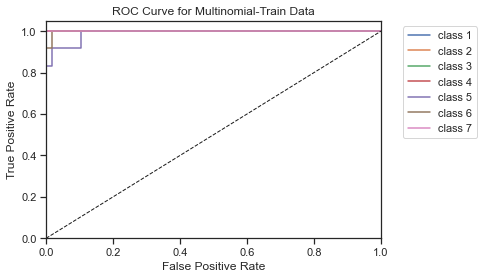

AUC for each of the classes in the order bending1, bending2,cycling,lying,sitting,standing,walking
0.8823529411764706 1.0 0.9375 0.9791666666666666 0.8958333333333333 1.0 1.0


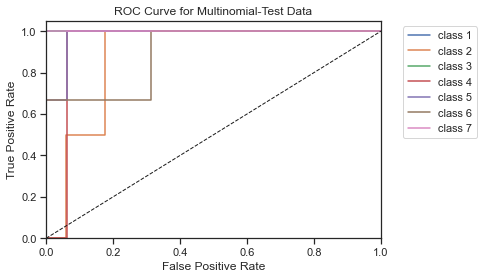

In [29]:
def draw_multi_ROC_curve(multi_l1_train_y, pred_prob_tr_Y,title):
    fp_rate=dict()
    tp_rate=dict()
    R_Auc={}

    for i in range(0,7,1):
        fp_rate[i], tp_rate[i], threshold= roc_curve(multi_l1_train_y,pred_prob_tr_Y[:, i],pos_label=i+1)
    #     print(fp_rate[i], tp_rate[i])
        R_Auc[i] = auc(fp_rate[i], tp_rate[i])
    plt.figure()

    for i in range(0,7,1):
        plt.plot(fp_rate[i],tp_rate[i],label='class %i'%(i+1)%R_Auc[i])
    
    print("AUC for each of the classes in the order bending1, bending2,cycling,lying,sitting,standing,walking")
    print(R_Auc[1],R_Auc[2],R_Auc[3],R_Auc[4],R_Auc[5],R_Auc[6],R_Auc[0])
    
    
    plt.plot([0, 1], [0, 1], 'k--',lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=2,bbox_to_anchor=(1.05,1.0))
    plt.title("ROC Curve for "+ title)
    plt.show()

    
pred_prob_tr_Y = multi_best_l_log_reg.predict_proba(multi_l1_train_x)
pred_prob_te_Y = multi_best_l_log_reg.predict_proba(multi_test_new_x)

draw_multi_ROC_curve(multi_l1_train_y, pred_prob_tr_Y, 'Multinomial-Train Data')
draw_multi_ROC_curve(multi_test_new_y, pred_prob_te_Y, 'Multinomial-Test Data')


Repeat 2(c)i using a Naiıve Bayes’ classifier. Use both Gaussian and Multi-
nomial priors and compare the results.

### Gaussian NB Model

In [30]:
from sklearn.naive_bayes import GaussianNB

gs_cv_scores=[]
gs_test_error=[]
gs_test_accuracy=[]
gs_train_accuracy=[]

for L in range(1,21,1):
    # contains time domain features (mean, median, std) of the time series - 'avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23'
    gs_training_data_features=get_time_domain_features_splitted_merged_multimonial(train_dfs,L);
    gs_l1_train_x, gs_l1_train_y = get_predictors_and_target_variable(L, gs_training_data_features);
    gs_test_new_features=get_time_domain_features_splitted_merged_multimonial(test_dfs,L)
    gs_test_new_x, gs_test_new_y = get_predictors_and_target_variable(L, gs_test_new_features)

    GS = GridSearchCV(GaussianNB(),param_grid={},cv=5,scoring='accuracy')
    GS.fit(gs_l1_train_x, gs_l1_train_y)
    
    gs_log_reg=GaussianNB()
    gs_log_reg.fit(gs_l1_train_x, gs_l1_train_y)    
    
    train_accuracy=gs_log_reg.score(gs_l1_train_x,gs_l1_train_y)
    test_accuracy=gs_log_reg.score(gs_test_new_x,gs_test_new_y)
                                                
#     print("Gaussian: l value:", L)
#     print("Gaussian: test error", 1-test_accuracy)
#     print('Gaussian: For l=',L,'Best CV Score:', GS.best_score_)
    
    gs_cv_scores.append(GS.best_score_)
    gs_train_accuracy.append(train_accuracy)
    gs_test_accuracy.append(test_accuracy)
    gs_test_error.append(1-test_accuracy)
    

    
l=np.arange(1,21,1);
gs_cv_scores_df= pd.DataFrame({'Split val: L':l,'Test Error':gs_test_error,'Test Accuracy':gs_test_accuracy,'Train Accuracy': gs_train_accuracy, 'CV score':gs_cv_scores})
gs_cv_scores_df

Split val: L  Test Error  Test Accuracy  Train Accuracy  CV score
0              1    0.157895       0.842105        0.956522  0.870330
1              2    0.315789       0.684211        1.000000  0.769231
2              3    0.157895       0.842105        0.971014  0.725275
3              4    0.157895       0.842105        0.985507  0.724176
4              5    0.157895       0.842105        0.985507  0.797802
5              6    0.210526       0.789474        0.985507  0.725275
6              7    0.368421       0.631579        1.000000  0.739560
7              8    0.263158       0.736842        0.985507  0.709890
8              9    0.263158       0.736842        1.000000  0.725275
9             10    0.263158       0.736842        1.000000  0.726374
10            11    0.315789       0.684211        1.000000  0.725275
11            12    0.368421       0.631579        1.000000  0.754945
12            13    0.315789       0.684211        1.000000  0.725275
13            14    0.263158       0.736842        1.000000  0.726374
14            15    0.210526       0.789474        1.000000  0.753846
15            16    0.210526       0.789474        1.000000  0.726374
16            17    0.368421       0.631579        1.000000  0.710989
17            18    0.315789       0.684211        1.000000  0.754945
18            19    0.368421       0.631579        1.000000  0.726374
19            20    0.263158       0.736842        1.000000  0.697802

### Confusion Matrix, Test Accuracy, Train Accuracy - Gaussian Model

In [31]:
gs_min_te_index = gs_test_error.index(min(gs_test_error))
best_l_gs = gs_min_te_index+1
print("As seen above, l=1 has least test error and cv score.So,Best l as per CV score/test error: ", best_l_gs)
print("The best cross validation score or accuracy achieved is ", max(gs_cv_scores))
print("Test score for best l is:", gs_test_accuracy[gs_min_te_index])
print("Train score for best l is:", gs_train_accuracy[gs_min_te_index])

gs_training_data_features=get_time_domain_features_splitted_merged_multimonial(train_dfs,best_l_gs);
gs_b_l1_train_x, gs_b_l1_train_y = get_predictors_and_target_variable(best_l_gs, gs_training_data_features);
gs_test_new_features=get_time_domain_features_splitted_merged_multimonial(test_dfs,best_l_gs)
gs_b_test_new_x, gs_b_test_new_y = get_predictors_and_target_variable(best_l_gs, gs_test_new_features)

    
print("******Train Data Confusion Matrix********")

gs_log_reg=GaussianNB()
gs_log_reg.fit(gs_b_l1_train_x, gs_b_l1_train_y) 

pred_tr_gs_y = gs_log_reg.predict(gs_b_l1_train_x)
print(confusion_matrix(gs_b_l1_train_y,pred_tr_gs_y))

print("******Test Data Confusion Matrix********")
pred_te_gs_y = gs_log_reg.predict(gs_b_test_new_x)
print(confusion_matrix(gs_b_test_new_y,pred_te_gs_y))

As seen above, l=1 has least test error and cv score.So,Best l as per CV score/test error:  1
The best cross validation score or accuracy achieved is  0.8703296703296705
Test score for best l is: 0.8421052631578947
Train score for best l is: 0.9565217391304348
******Train Data Confusion Matrix********
[[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  1  0  0 10  1  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]]
******Test Data Confusion Matrix********
[[2 0 0 0 0 0 0]
 [0 1 0 0 1 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 0 3]]


### ROC-Gaussian Model

AUC for each of the classes in the order bending1, bending2,cycling,lying,sitting,standing,walking
0.9961538461538462 1.0 1.0 0.9941520467836257 0.9985380116959064 1.0 1.0


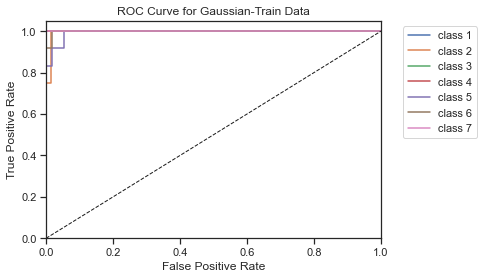

AUC for each of the classes in the order bending1, bending2,cycling,lying,sitting,standing,walking
1.0 1.0 1.0 0.9166666666666666 0.9583333333333334 1.0 1.0


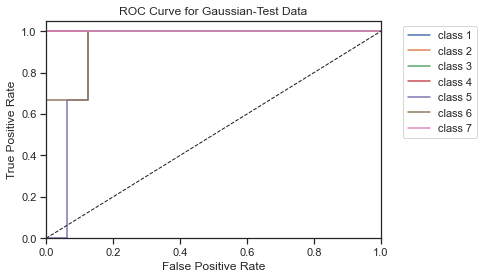

In [32]:
pred_prob_tr_Y = gs_log_reg.predict_proba(gs_b_l1_train_x)
pred_prob_te_Y = gs_log_reg.predict_proba(gs_b_test_new_x)

draw_multi_ROC_curve(gs_b_l1_train_y, pred_prob_tr_Y, 'Gaussian-Train Data')
draw_multi_ROC_curve(gs_b_test_new_y, pred_prob_te_Y, 'Gaussian-Test Data')

### Multinomial Naive Bayes Classifier

In [33]:
from sklearn.naive_bayes import GaussianNB

nve_b_cv_scores=[]
nve_b_test_error=[]
nve_b_test_accuracy=[]
nve_b_train_accuracy=[]

for L in range(1,21,1):
    # contains time domain features (mean, median, std) of the time series - 'avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23'
    nve_b_training_data_features=get_time_domain_features_splitted_merged_multimonial(train_dfs,L);
    nve_b_train_x, nve_b_train_y = get_predictors_and_target_variable(L, nve_b_training_data_features);
    nve_b_test_new_features=get_time_domain_features_splitted_merged_multimonial(test_dfs,L)
    nve_b_test_new_x, nve_b_test_new_y = get_predictors_and_target_variable(L, nve_b_test_new_features)

    GS = GridSearchCV(MultinomialNB() ,param_grid={},cv=5,scoring='accuracy')
    GS.fit(nve_b_train_x, nve_b_train_y)
    
    nve_b_log_reg=MultinomialNB() 
    nve_b_log_reg.fit(nve_b_train_x, nve_b_train_y)    
    
    train_accuracy=nve_b_log_reg.score(nve_b_train_x,nve_b_train_y)
    test_accuracy=nve_b_log_reg.score(nve_b_test_new_x,nve_b_test_new_y)
                                                
#     print("Gaussian: l value:", L)
#     print("Gaussian: test error", 1-test_accuracy)
#     print('Gaussian: For l=',L,'Best CV Score:', GS.best_score_)
    
    nve_b_cv_scores.append(GS.best_score_)
    nve_b_train_accuracy.append(train_accuracy)
    nve_b_test_accuracy.append(test_accuracy)
    nve_b_test_error.append(1-test_accuracy)
    

    
l=np.arange(1,21,1);
nve_b_cv_scores_df= pd.DataFrame({'Split val: L':l,'Test Error':nve_b_test_error,'Test Accuracy':nve_b_test_accuracy,'Train Accuracy': nve_b_train_accuracy, 'CV score':nve_b_cv_scores})
nve_b_cv_scores_df

Split val: L  Test Error  Test Accuracy  Train Accuracy  CV score
0              1    0.157895       0.842105        0.927536  0.796703
1              2    0.157895       0.842105        0.913043  0.825275
2              3    0.105263       0.894737        0.913043  0.825275
3              4    0.157895       0.842105        0.927536  0.810989
4              5    0.210526       0.789474        0.942029  0.768132
5              6    0.210526       0.789474        0.927536  0.782418
6              7    0.157895       0.842105        0.913043  0.796703
7              8    0.157895       0.842105        0.942029  0.782418
8              9    0.210526       0.789474        0.942029  0.768132
9             10    0.157895       0.842105        0.942029  0.782418
10            11    0.105263       0.894737        0.942029  0.782418
11            12    0.105263       0.894737        0.942029  0.753846
12            13    0.105263       0.894737        0.942029  0.782418
13            14    0.157895       0.842105        0.942029  0.768132
14            15    0.105263       0.894737        0.942029  0.782418
15            16    0.105263       0.894737        0.942029  0.768132
16            17    0.105263       0.894737        0.942029  0.768132
17            18    0.157895       0.842105        0.942029  0.768132
18            19    0.157895       0.842105        0.942029  0.739560
19            20    0.157895       0.842105        0.942029  0.753846

In [34]:
nve_b_min_te_index = nve_b_test_error.index(min(nve_b_test_error))
best_l_nve_b = nve_b_min_te_index+1
print("Best l as per CV score/test error: ", best_l_nve_b)
print("The best cross validation score or accuracy achieved is ", max(nve_b_cv_scores))
print("Test score for best l is:", nve_b_test_accuracy[nve_b_min_te_index])
print("Train score for best l is:", nve_b_train_accuracy[nve_b_min_te_index])

nve_b_training_data_features=get_time_domain_features_splitted_merged_multimonial(train_dfs,best_l_nve_b);
nve_b_l1_train_x, nve_b_l1_train_y = get_predictors_and_target_variable(best_l_nve_b, nve_b_training_data_features);
nve_b_test_new_features=get_time_domain_features_splitted_merged_multimonial(test_dfs,best_l_nve_b)
nve_b_test_new_x, nve_b_test_new_y = get_predictors_and_target_variable(best_l_nve_b, nve_b_test_new_features)

    
print("******Train Data Confusion Matrix********")

multinb_log_reg=MultinomialNB() 
multinb_log_reg.fit(nve_b_l1_train_x, nve_b_l1_train_y) 

pred_tr_nve_b_y = multinb_log_reg.predict(nve_b_l1_train_x)
print(confusion_matrix(nve_b_l1_train_y,pred_tr_nve_b_y))

print("******Test Data Confusion Matrix********")
pred_te_nve_b_y = multinb_log_reg.predict(nve_b_test_new_x)
print(confusion_matrix(nve_b_test_new_y,pred_te_nve_b_y))

Best l as per CV score/test error:  3
The best cross validation score or accuracy achieved is  0.8252747252747253
Test score for best l is: 0.8947368421052632
Train score for best l is: 0.9130434782608695
******Train Data Confusion Matrix********
[[ 4  0  0  0  1  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 1  0  0  1 10  0  0]
 [ 0  0  0  0  2 10  0]
 [ 0  0  0  0  0  0 12]]
******Test Data Confusion Matrix********
[[2 0 0 0 0 0 0]
 [1 1 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


### ROC- Multinomial Naive Bayes Classifier

AUC for each of the classes in the order bending1, bending2,cycling,lying,sitting,standing,walking
0.9923076923076923 1.0 0.9970760233918128 0.9795321637426901 0.986842105263158 1.0 0.99375


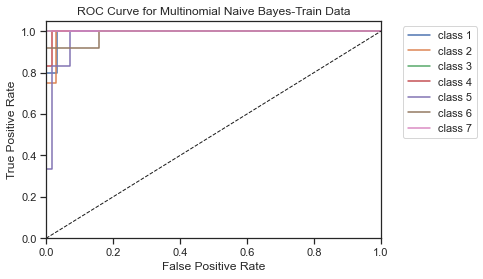

AUC for each of the classes in the order bending1, bending2,cycling,lying,sitting,standing,walking
1.0 1.0 1.0 0.9375 0.9375 1.0 1.0


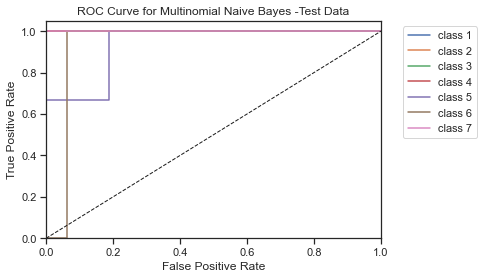

In [35]:
pred_prob_tr_Y =multinb_log_reg.predict_proba(nve_b_l1_train_x)
pred_prob_te_Y =multinb_log_reg.predict_proba(nve_b_test_new_x )


draw_multi_ROC_curve(nve_b_l1_train_y, pred_prob_tr_Y, 'Multinomial Naive Bayes-Train Data')
draw_multi_ROC_curve(nve_b_test_new_y, pred_prob_te_Y, 'Multinomial Naive Bayes -Test Data')

### Comparison of Results - Gaussian Naive Bayes, Multinomial Naive Bayes


######## GAUSSIAN ###########
l=1 has least test error and cv score.So,Best l as per CV score/test error:  1
The best cross validation score or accuracy achieved is  0.8703296703296705
Test score for best l is: 0.8421052631578947
Train score for best l is: 0.9565217391304348
AUC - Test data - for each of the classes in the order bending1, bending2,cycling,lying,sitting,standing,walking
1.0 1.0 1.0 0.9166666666666666 0.9583333333333334 1.0 1.0

######## Multinomial Naive Bayes #######
Best l as per CV score/test error:  3
The best cross validation score or accuracy achieved is  0.8252747252747253
Test score for best l is: 0.8947368421052632
Train score for best l is: 0.9130434782608695
******Train Data Confusion Matrix********

AUC for each of the classes in the order bending1, bending2,cycling,lying,sitting,standing,walking
1.0 1.0 1.0 0.9375 0.9375 1.0 1.0


### Comparing the AUC scores, the multinomial naive bayes one is much better. Also, the test accuracy is higher when we use multinomial naive bayes.  As a result, I feel multinomial naive bayes model performs  better in this case.


iii. Which method is better for multi-class classification in this problem?

### Best method for multi class classification

<b> Multinomial Naive bayes classfier<b> is better for multi-class classfication in this problem, after considering the AUC scores, test accuracy, overall cv scores, as printed in the previous cells

## ISLR 4.8.3

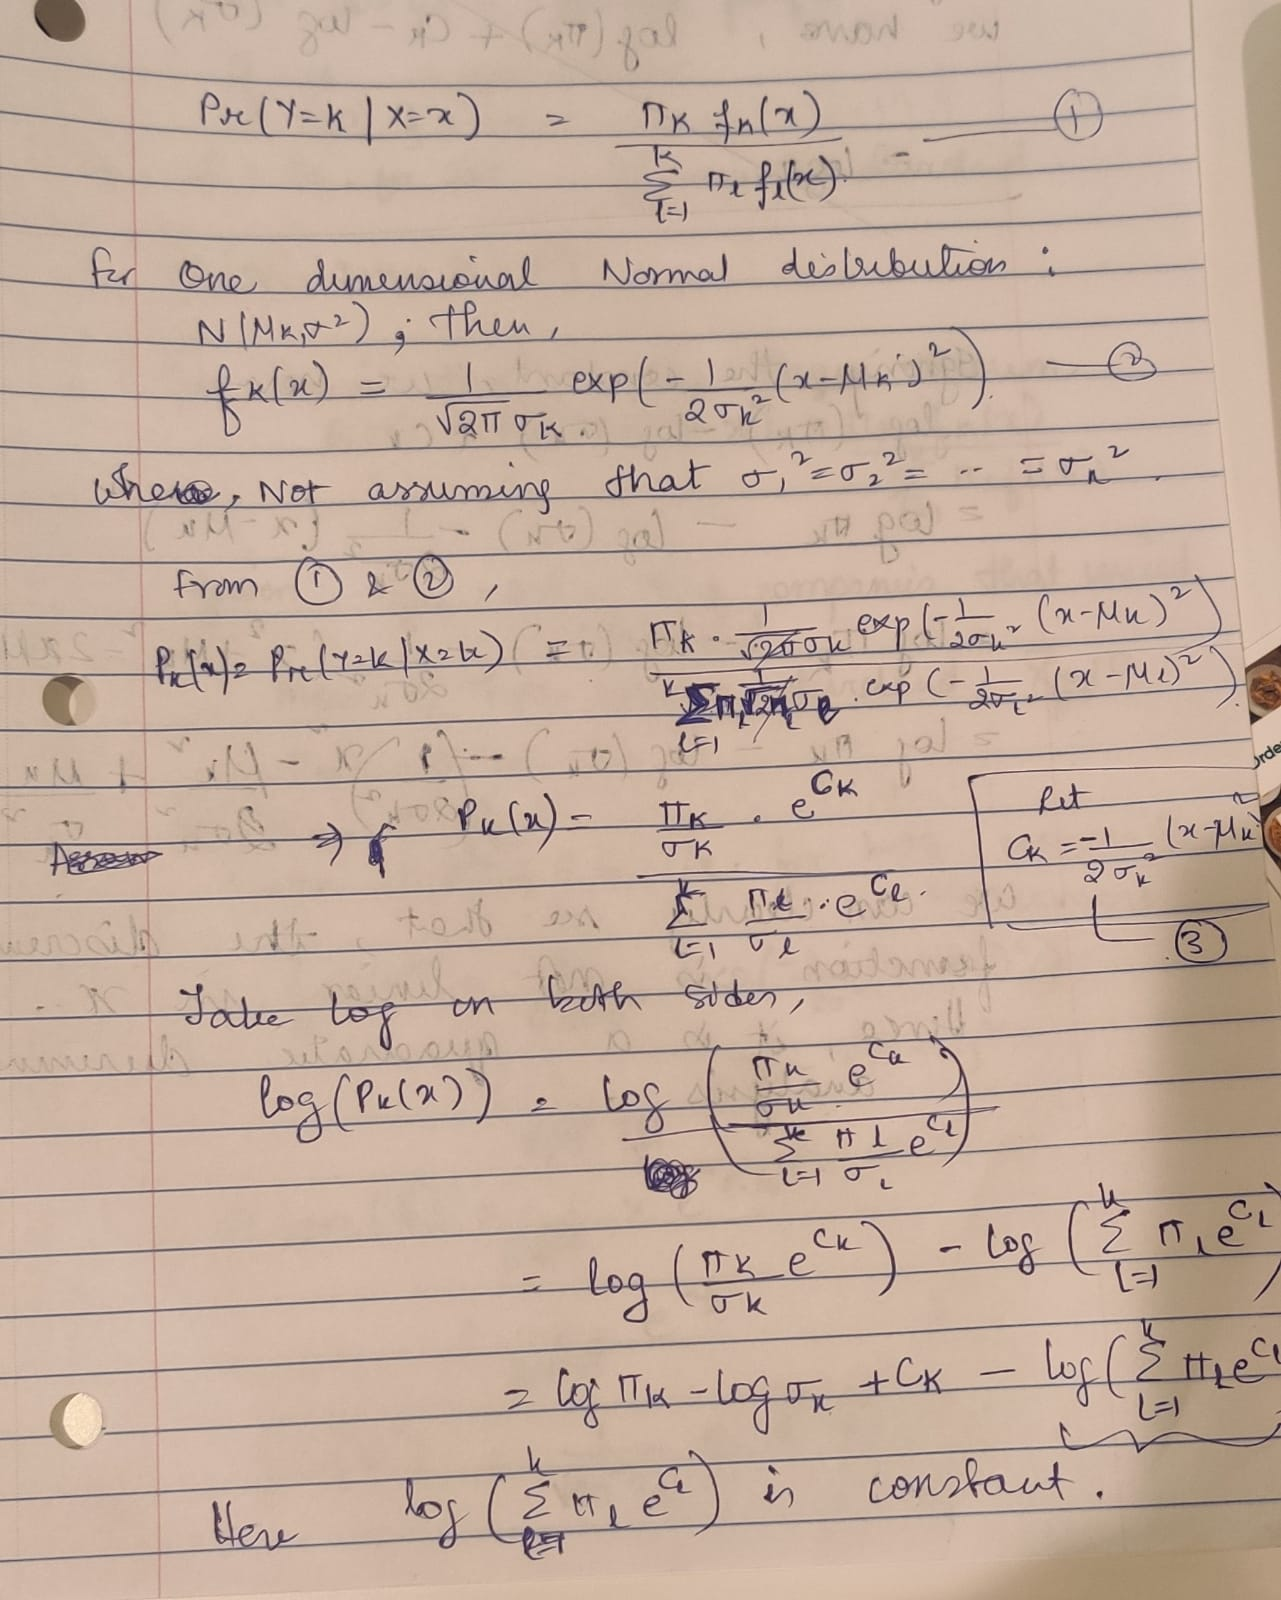

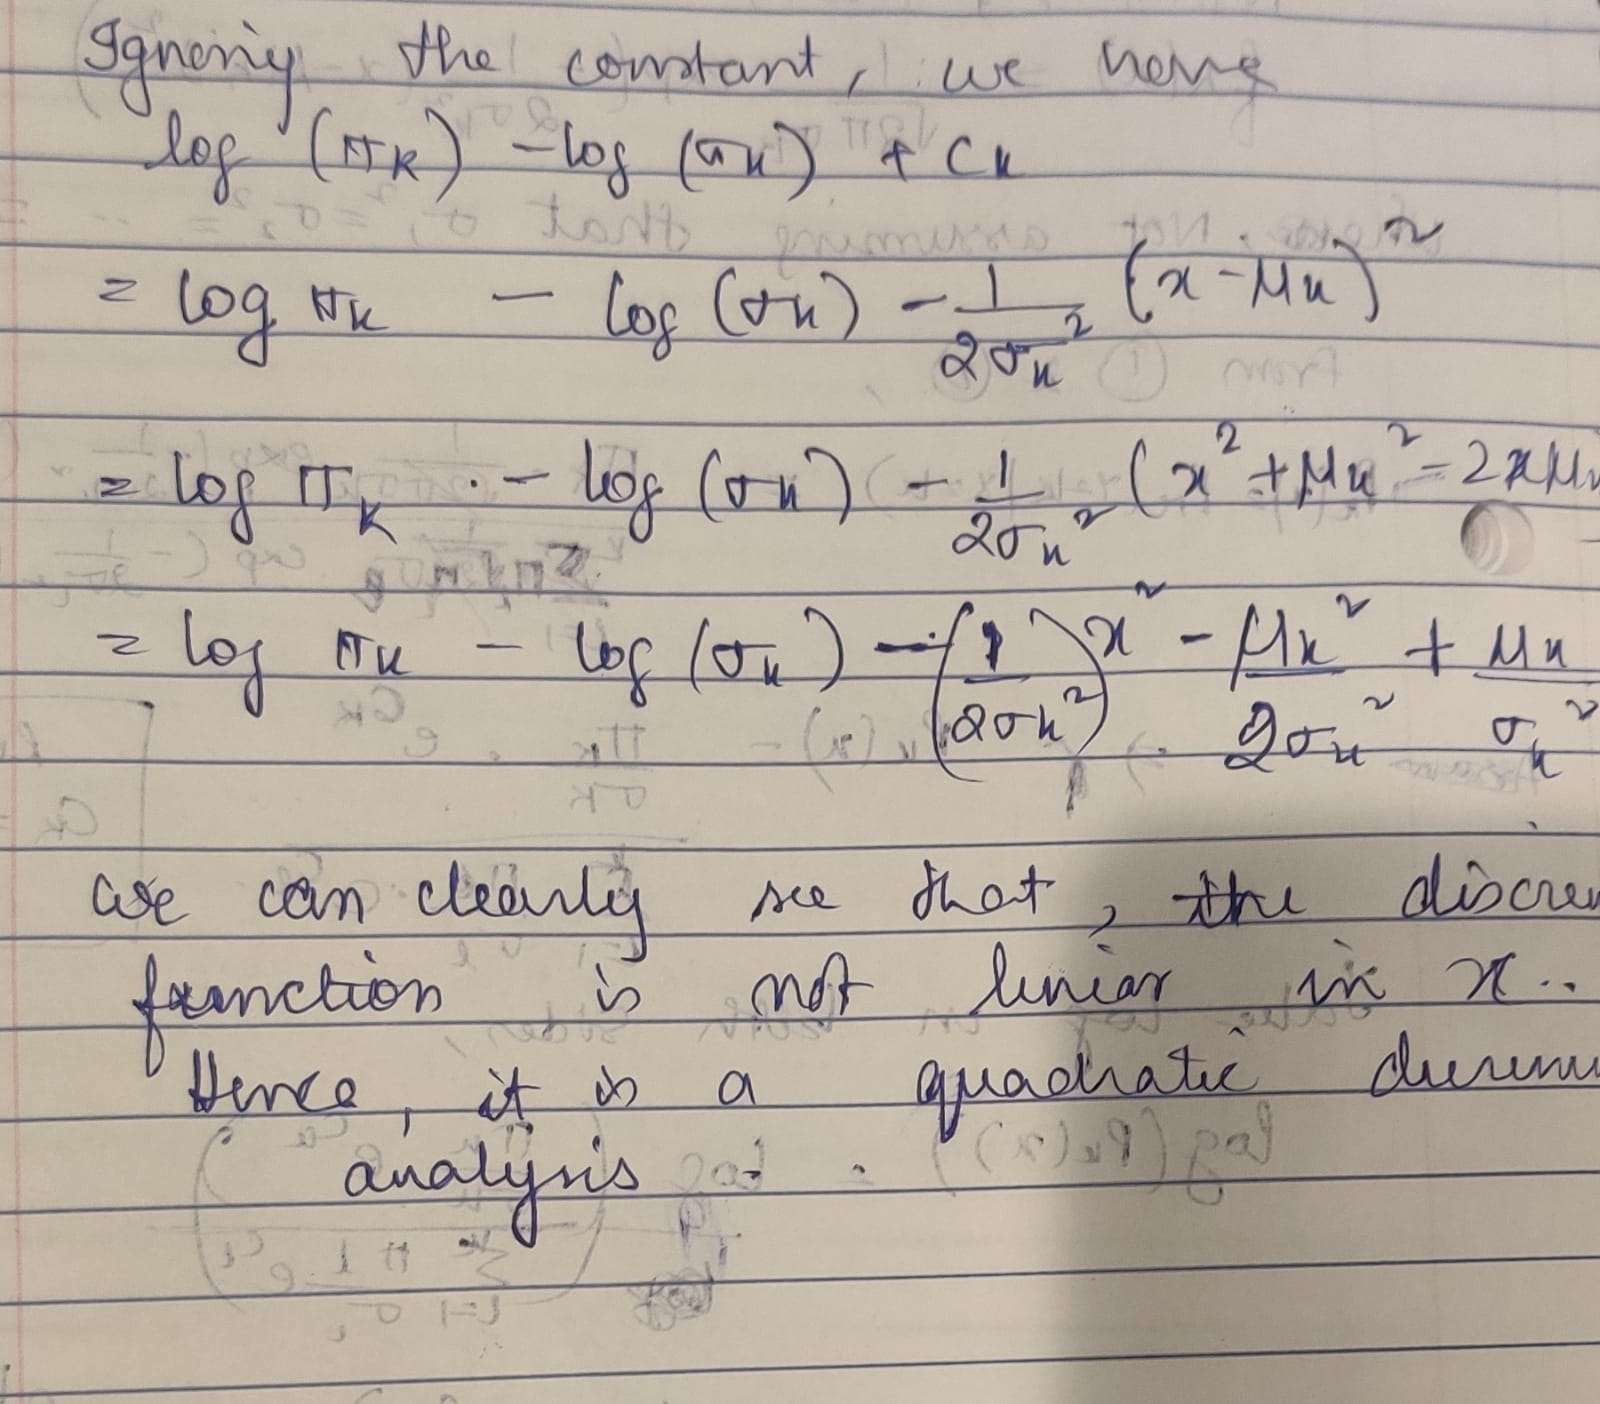

### ISLR 4.8.7

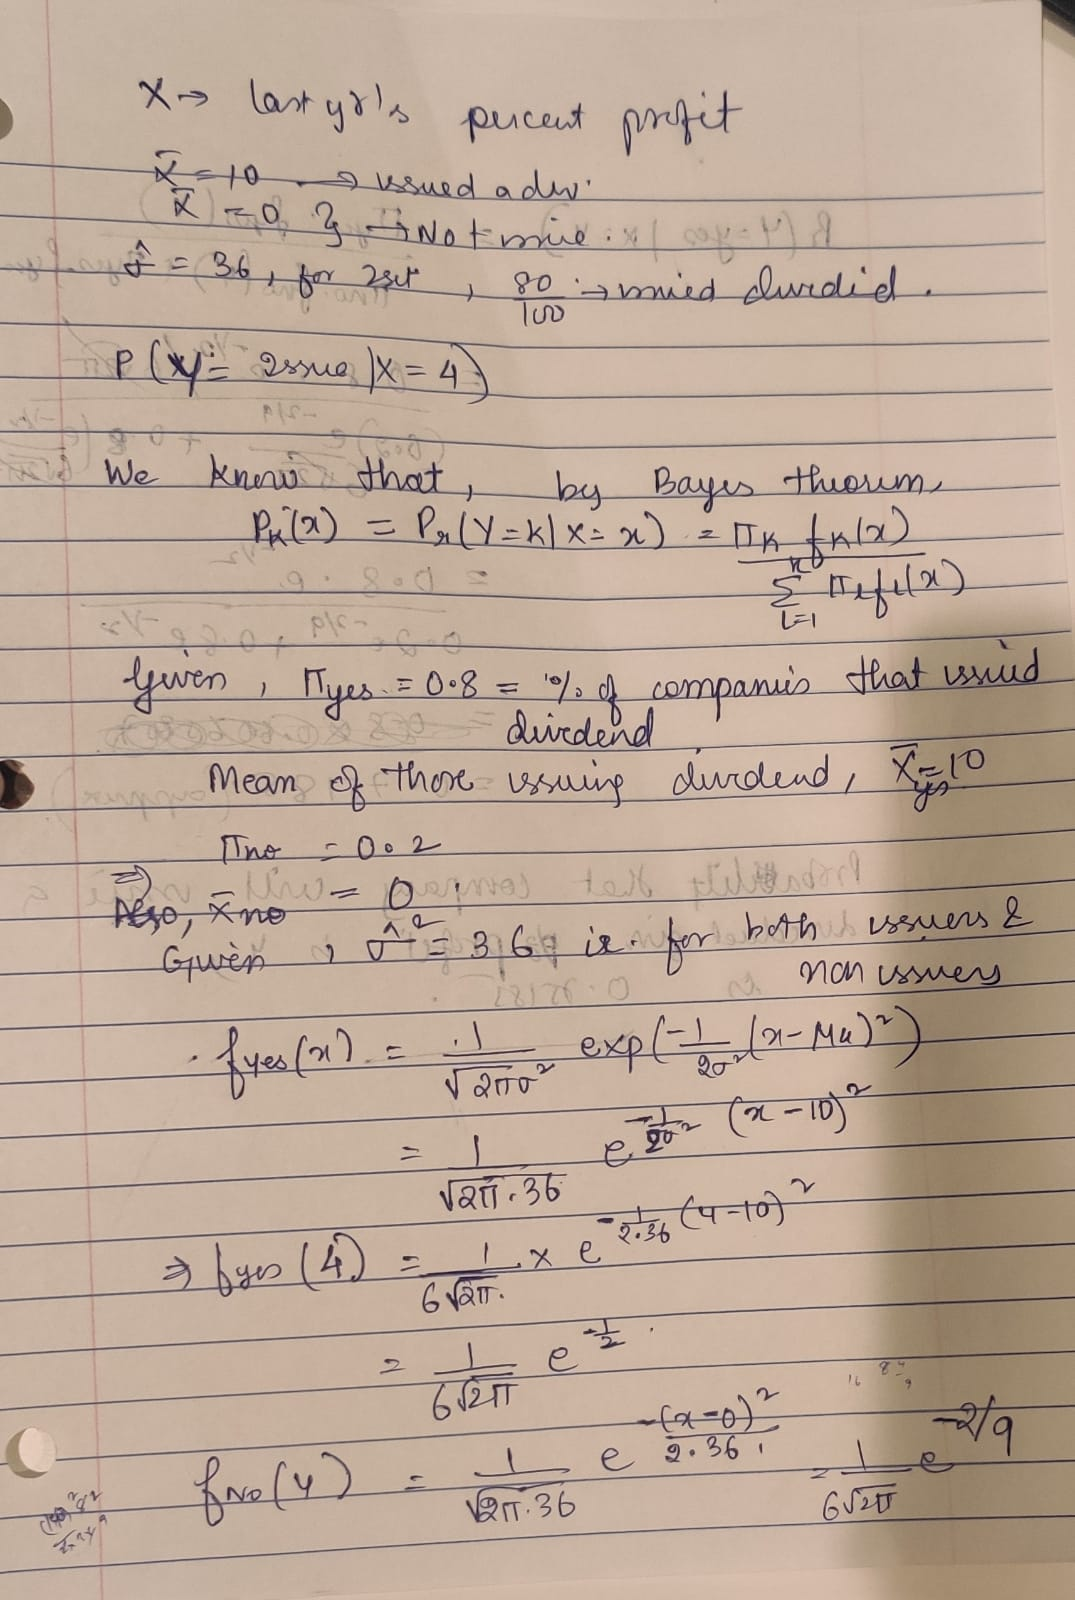

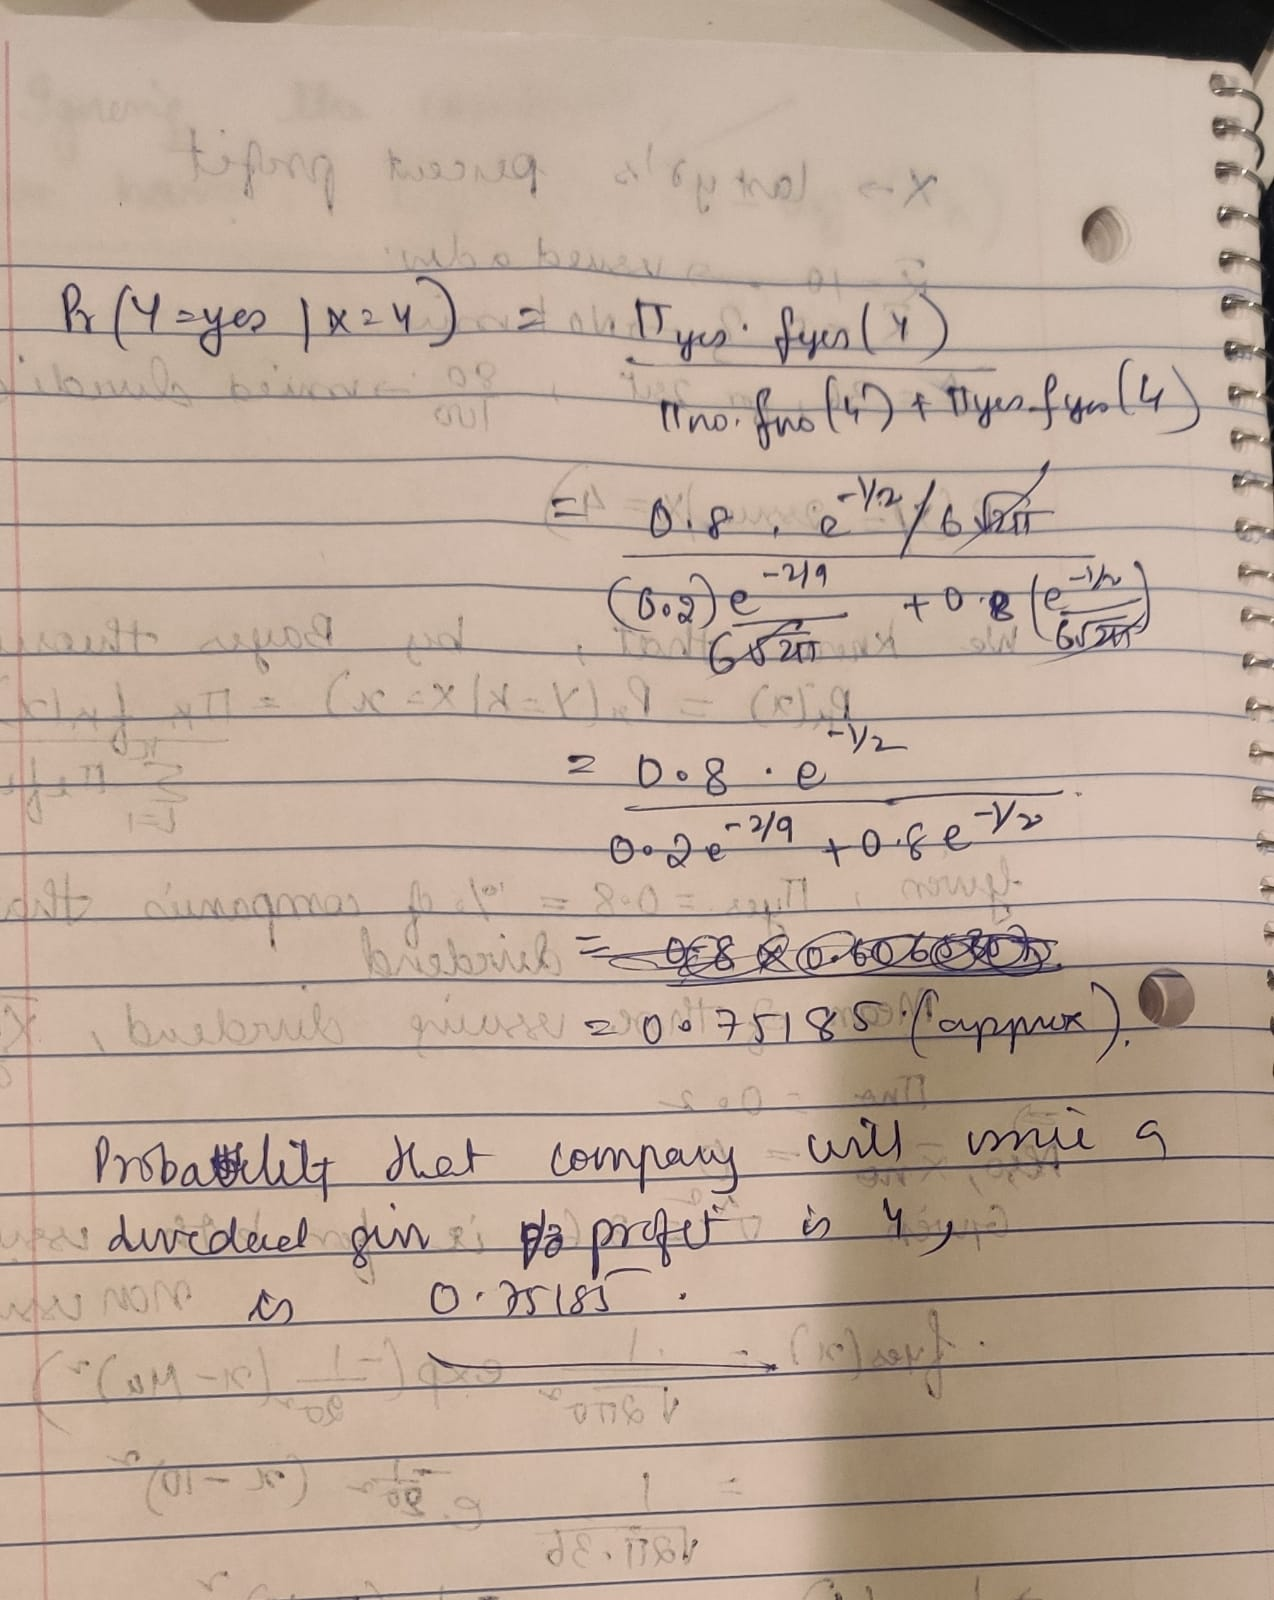

https://medium.com/@kunanba/what-is-roc-auc-and-how-to-visualize-it-in-python-f35708206663
https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499
https://stackoverflow.com/questions/36271166/how-to-get-comparable-and-reproducible-results-from-

https://medium.com/@aditya97p/l1-and-l2-regularization-237438a9caa6

https://blog.quantinsti.com/linear-regression-models-scikit-learn/

https://towardsdatascience.com/feature-selection-using-logistic-regression-model-efc949569f58

https://www.quora.com/What-may-cause-a-huge-difference-between-cross-validation-accuracy-and-test-accuracy
